In [1]:
import os
import rootutils

rootutils.setup_root(os.getcwd(), indicator=".project-root", pythonpath=True)

from torchvision import transforms
import torch
from src.data.components.graphs_datamodules import (
    SplitPatches,
)
from src.data.mnist_datamodule import MNISTDataModule
from src.data.mnist_datamodule import add_channel
import src.data.components.graphs_datamodules as gd
from torchvision.datasets import MNIST
from torch.utils.data import ConcatDataset, Dataset, random_split

In [24]:
example = torch.arange(32, dtype=torch.float32).view(1, 2, 4, 4)
s = SplitPatches(2)

s(example)

tensor([[[ 0.,  1.,  4.,  5., 16., 17., 20., 21.],
         [ 2.,  3.,  6.,  7., 18., 19., 22., 23.],
         [ 8.,  9., 12., 13., 24., 25., 28., 29.],
         [10., 11., 14., 15., 26., 27., 30., 31.]]])

In [23]:
example = torch.arange(4).view(2, 2)
example.flatten()

tensor([0, 1, 2, 3])

In [13]:
from src.models.components.plot import restore_tensor
import matplotlib.pyplot as plt

base_transforms = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Resize((26, 26)),
        add_channel,
        SplitPatches(2),
    ]
)

aug_transforms_train = gd.PatchAugmentations(
    prob=1.0,
    size=26,
    patch_size=2,
)

aug_transforms_val = gd.PatchAugmentations(
    prob=1.0,
    size=26,
    patch_size=2,
    is_validation=True,
)

dual_transforms_train = gd.DualOutputTransform(base_transforms, aug_transforms_train)

dual_transforms_val = gd.DualOutputTransform(base_transforms, aug_transforms_val)

trainset = MNIST("../data/", train=True, transform=dual_transforms_train)
testset = MNIST("../data/", train=False, transform=dual_transforms_val)
train_ratio, val_ratio, test_ratio, leftover_ratio = [2_000, 2_00, 1_00, 67_700]
size_testset = len(testset)
size_trainset = len(trainset)
data_train, _ = random_split(
    dataset=trainset,
    lengths=[train_ratio, size_trainset - train_ratio],
    generator=torch.Generator().manual_seed(42),
)
# dataset = ConcatDataset(datasets=[trainset, testset])
data_val, data_test, _ = random_split(
    dataset=testset,
    lengths=[val_ratio, test_ratio, size_testset - val_ratio - test_ratio],
    generator=torch.Generator().manual_seed(42),
)

train_dataset = gd.GridGraphDataset(grid_size=13, dataset=data_train, channels=[0])

train_loader = gd.DenseGraphDataLoader(
    dataset=train_dataset,
    batch_size=64,
    num_workers=7,
    pin_memory=False,
    persistent_workers=7 > 0,
)

In [14]:
for el in train_dataset:
    break

In [15]:
el[1].shape

torch.Size([8, 1, 169, 4])

In [12]:
el.node_features.shape

torch.Size([512, 36, 16])

In [10]:
for el in train_loader:
    break

In [ ]:
imgs = el.node_features
args = el.argsort_augmented_features
p = el.perms

In [ ]:
p[[0, 64, 128, 192, 256, 320, 384, 448]]

tensor([3, 6, 1, 0, 5, 7, 4, 2])

In [ ]:
probs = torch.tensor(
    [[0.0, 0.4, 0.6], [0.0, 0.6, 0.4], [0.0, 0.4, 0.6], [0.0, 0.9, 0.1]]
)


avg_probs = probs.mean(dim=0)
log_avg_probs = torch.log(avg_probs + 1e-12)
entropy = -torch.sum(avg_probs * log_avg_probs)  # scalar
entropy

tensor(0.6819)

In [ ]:
log_avg_probs

tensor([-27.6310,  -0.5534,  -0.8557])

In [ ]:
probs = torch.tensor(
    [[0.1, 0.3, 0.6], [0.4, 0.2, 0.4], [0.5, 0.4, 0.1], [0.8, 0.1, 0.1]]
)

probs_expanded = probs.unsqueeze(-1).unsqueeze(-1)

perms_buffer = torch.tensor([[[1, 0], [0, 1]], [[0, 1], [1, 0]], [[1, 0], [1, 0]]])

In [ ]:
perm = torch.sum(probs_expanded * perms_buffer.unsqueeze(0), dim=1)
perm = torch.sum(probs_expanded * perms_buffer, dim=1)

In [ ]:
res = [img[arg, :] for img, arg in zip(imgs, args)]
res = torch.stack(res, dim=0)

In [ ]:
args[192]

tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35])

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import networkx as nx
# import math

# # from torch.nn.attention import SDPBackend
# from typing import Optional
# from src.models.components.custom_pytorch_functions import RMSNorm
# from src.models.components.rotary_embedding import BaseRotaryEmbedding


# """
# adapted from https://github.com/jadore801120/attention-is-all-you-need-pytorch
# """


# class Transformer(nn.Module):
#     def __init__(
#         self,
#         hidden_dim: int,
#         num_heads: int,
#         ppf_hidden_dim: int,
#         num_layers: int,
#         dropout: float = 0.1,
#         rope: Optional[BaseRotaryEmbedding] = None,
#     ):
#         super().__init__()
#         self.num_layers = num_layers
#         self.ppf_hidden_dim = ppf_hidden_dim  # TBDeleted
#         # self.embedding_layer = EmbeddingLayer(
#         #     config.vocab_size, config.d_model, config.max_len
#         # )
#         self.blocks = nn.ModuleList(
#             [
#                 TransformerBlock(hidden_dim, num_heads, dropout, num_layers, rope)
#                 for _ in range(num_layers)
#             ]
#         )

#         self.rope = rope

#         # self.head = nn.Linear(config.d_model, config.vocab_size, bias=False)

#     def forward(
#         self, x: torch.Tensor, is_encoder: bool, a, mask: Optional[torch.Tensor] = None
#     ) -> torch.Tensor:
#         # output = self.embedding_layer(input_ids)

#         for block in self.blocks:
#             x = block(x, is_encoder, a, mask)

#         output = x
#         print(f'Img 0 {output[0][1:][a[0], :][4][11]}')
#         print(f'Img 64 {output[64][1:][a[64], :][4][11]}')
#         print()
#         # output = self.head(output)
#         return output

#     @property
#     def is_rope(self) -> bool:
#         return self.rope is not None


# class TransformerBlock(nn.Module):
#     """TransformerBlock Module.

#     Args:
#         layer_id (int): Identifier for the layer.
#         model_args (ModelArgs): Model configuration arguments.

#     Attributes:
#         n_heads (int): Number of attention heads.
#         dim (int): Dimension size of the model.
#         head_dim (int): Dimension size of each attention head.
#         attention (Attention): Attention module.
#         feed_forward (FeedForward): FeedForward module.
#         layer_id (int): Identifier for the layer.
#         attention_norm (RMSNorm): Layer normalization for attention output.
#         ffn_norm (RMSNorm): Layer normalization for feedforward output.

#     """

#     def __init__(
#         self,
#         hidden_dim: torch.Tensor,
#         n_head: torch.Tensor,
#         dropout: float,
#         num_layers: Optional[int] = None,
#         rope: Optional[BaseRotaryEmbedding] = None,
#     ):
#         super().__init__()
#         self.attention_layer = SelfAttention(n_head, hidden_dim, dropout, rope)
#         self.feed_forward_layer = FeedForward(
#             hidden_dim=hidden_dim,
#             ffn_hidden_dim=hidden_dim,  # I put the same since this is computed in feed forward layer
#             multiple_of=32,  # fine tune that
#             ffn_dim_multiplier=None,
#         )

#         self.attention_norm = RMSNorm(hidden_dim=hidden_dim, eps=1e-5)
#         self.ffn_norm = RMSNorm(hidden_dim=hidden_dim, eps=1e-5)
#         self.num_layers = num_layers

#         # if model_args.depth_init:
#         #     self.weight_init_std = 0.02 / (2 * (self.layer_id + 1)) ** 0.5
#         # else:
#         #     self.weight_init_std = 0.02 / (2 * self.num_layers) ** 0.5

#         self.weight_init_std = 0.02 / (2 * self.num_layers) ** 0.5

#     # def forward(
#     #     self,
#     #     x: torch.Tensor,
#     #     freqs_cis: torch.Tensor,
#     # ):
#     #     """Perform a forward pass through the TransformerBlock.

#     #     Args:
#     #         x (torch.Tensor): Input tensor.
#     #         freqs_cis (torch.Tensor): Precomputed cosine and sine frequencies.

#     #     Returns:
#     #         torch.Tensor: Output tensor after applying attention and feedforward layers.

#     #     """
#     #     h = x + self.attention(self.attention_norm(x), freqs_cis)
#     #     return h + self.feed_forward(self.ffn_norm(h))

#     def forward(
#         self,
#         x: torch.Tensor,
#         is_encoder: bool,
#         a,
#         attention_mask: Optional[torch.Tensor] = None,
#     ) -> torch.Tensor:

#         out_attention = self.attention_layer(
#             self.attention_norm(x), a, is_encoder, attention_mask
#         )

#         x = x + out_attention

#         out_feed_forward = self.feed_forward_layer(self.ffn_norm(x), a)
#         x = x + out_feed_forward
#         return x

#     def init_weights(self):
#         for norm in (self.attention_norm, self.ffn_norm):
#             norm.reset_parameters()
#         self.attention.init_weights(self.weight_init_std)
#         self.feed_forward.init_weights(self.weight_init_std)


# class FeedForward(nn.Module):
#     """FeedForward module.

#     Args:
#         dim (int): Input dimension.
#         hidden_dim (int): Hidden dimension of the feedforward layer.
#         multiple_of (int): Value to ensure hidden dimension is a multiple of this value.
#         ffn_dim_multiplier (Optional[float]): Custom multiplier for hidden dimension. Defaults to None.

#     Attributes:
#         w1 (Linear): Linear transformation for the first layer.
#         w2 (Linear): Linear transformation for the second layer.
#         w3 (Linear): Linear transformation for the third layer.

#     """

#     def __init__(
#         self,
#         hidden_dim: int,
#         ffn_hidden_dim: int,
#         multiple_of: int,
#         dropout: Optional[float] = 0.0,
#         ffn_dim_multiplier: Optional[float] = None,
#     ):
#         super().__init__()
#         ffn_hidden_dim = int(2 * ffn_hidden_dim / 3)
#         # custom dim factor multiplier
#         if ffn_dim_multiplier is not None:
#             ffn_hidden_dim = int(ffn_dim_multiplier * ffn_hidden_dim)
#         ffn_hidden_dim = multiple_of * (
#             (ffn_hidden_dim + multiple_of - 1) // multiple_of
#         )

#         self.w1 = nn.Linear(hidden_dim, ffn_hidden_dim, bias=False)
#         self.w2 = nn.Linear(ffn_hidden_dim, hidden_dim, bias=False)
#         self.w3 = nn.Linear(hidden_dim, ffn_hidden_dim, bias=False)

#         self.dropout = torch.nn.Dropout(dropout)

#     def forward(self, x: torch.Tensor, a) -> torch.Tensor:
#         x = self.w2(F.silu(self.w1(x)) * self.w3(x))
#         x = self.dropout(x)
#         return x

#     def init_weights(self, init_std: float):
#         nn.init.trunc_normal_(self.w1.weight, mean=0.0, std=0.02)
#         for linear in (self.w2, self.w3):
#             nn.init.trunc_normal_(linear.weight, mean=0.0, std=init_std)


# class SelfAttention(torch.nn.Module):
#     def __init__(
#         self,
#         n_head: int,
#         hidden_dim: int,
#         dropout: float,
#         rope: Optional[BaseRotaryEmbedding] = None,
#     ):
#         super().__init__()

#         self.n_head = n_head
#         self.hidden_dim = hidden_dim

#         self.input_projection = nn.Linear(hidden_dim, 3 * hidden_dim, bias=False)
#         self.output_projection = nn.Linear(hidden_dim, hidden_dim, bias=False)
#         self.dropout = nn.Dropout(dropout)
#         self.rope = rope

#     def forward(
#         self,
#         x: torch.Tensor,
#         a,
#         is_encoder: bool = True,
#         mask: Optional[torch.Tensor] = None,
#     ) -> torch.Tensor:
#         # x: b x nn x nn x dv
#         batch_size, num_nodes = x.size(0), x.size(1)
#         projected = self.input_projection(x)

#         device = x.device

#         # print(f'Img 0 {x[0][1:][a[0], :][4][11]}')
#         # print(f'Img 64 {x[64][1:][a[64], :][4][11]}')
#         # print()

#         q_chunk, k_chunk, v_chunk = torch.chunk(projected, chunks=3, dim=-1)
#         query = q_chunk.view(batch_size, num_nodes, self.n_head, -1).transpose(1, 2)
#         key = k_chunk.view(batch_size, num_nodes, self.n_head, -1).transpose(1, 2)
#         value = v_chunk.view(batch_size, num_nodes, self.n_head, -1).transpose(1, 2)
#         if self.rope:
#             query = self.rope.rotate_queries_or_keys(query)
#             key = self.rope.rotate_queries_or_keys(key)

#         if mask is None:
#             attn_mask = get_neighborhood_mask(num_nodes, is_encoder)
#         else:
#             attn_mask = mask
#         attn_mask = attn_mask.to(device)
#         # attn_mask = attn_mask.unsqueeze(1).unsqueeze(
#         #     2
#         # )  # Shape: (batch_size, 1, 1, num_nodes)
#         # attn_mask = attn_mask.expand(-1, self.n_head, num_nodes, -1)

#         # with torch.nn.attention.sdpa_kernel(
#         #     [
#         #         SDPBackend.FLASH_ATTENTION,
#         #         SDPBackend.EFFICIENT_ATTENTION,
#         #         SDPBackend.MATH,
#         #     ]
#         # ):
#         attention_output = F.scaled_dot_product_attention(
#             query=query,
#             key=key,
#             value=value,
#             attn_mask=attn_mask,
#             is_causal=False,
#         )

#         output = self.output_projection(attention_output.transpose(1, 2).flatten(-2))
#         output = self.dropout(output)
#         return output


# def get_neighborhood_mask(num_nodes: int, is_encoder: bool):
#     if is_encoder:
#         n = num_nodes - 1
#     else:
#         n = num_nodes
#     n = int(math.sqrt(n))
#     G = nx.grid_2d_graph(n, n)
#     A = torch.tensor(nx.to_numpy_array(G))
#     mask = A + torch.eye(A.shape[0])
#     if is_encoder:
#         mask = F.pad(mask, (1, 0, 1, 0), value=1)
#     mask = mask.bool()
#     return mask


In [ ]:
import torch
from typing import Tuple, Optional, Any
import torch.nn as nn
import torch.nn.functional as F

# from src.models.components.custom_graph_transformer import Transformer
from src.models.components.llama_graph_transformer import Transformer


class GraphEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.summary_node = nn.Parameter(torch.randn(1, 1, 256))
        # nn.init.trunc_normal_(self.summary_node, std=0.02)
        self.projection_in = nn.Linear(16, 256)

        self.graph_transformer = Transformer(
            hidden_dim=256,
            num_heads=4,
            ppf_hidden_dim=-1,
            num_layers=4,
            dropout=0.1,
        )
        self.fc_in = nn.Linear(256, 256)
        self.layer_norm = nn.LayerNorm(256)
        self.dropout = nn.Dropout(0.1)

    def add_emb_node_and_feature(
        self,
        node_features: torch.Tensor,
        edge_features: torch.Tensor,
        mask: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        batch_size = node_features.size(0)
        cls_tokens = self.summary_node.expand(batch_size, -1, -1)
        node_features = torch.cat([cls_tokens, node_features], dim=1)  # (B, N+1, D)
        mask = F.pad(mask, (1, 0), value=1)
        return node_features, edge_features, mask

    def init_message_matrix(
        self,
        node_features: torch.Tensor,
        edge_features: torch.Tensor,
        mask: torch.Tensor,
        arg,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        x1 = node_features[0][arg[0], :]
        x2 = node_features[64][arg[64], :]
        # print(x1[4][11])
        # print(x2[4][11])
        node_features, edge_features, mask = self.add_emb_node_and_feature(
            node_features, edge_features, mask
        )
        y1 = node_features[0][1:][arg[0], :]
        y2 = node_features[64][1:][arg[64], :]
        # print(y1[4][11])
        # print(y2[4][11])
        # print(node_features[0][0][11])
        # print(node_features[11][0][11])
        x = self.layer_norm(self.dropout(self.fc_in(node_features)))
        return x, mask

    def read_out_message_matrix(
        self, x: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        node_features = x
        graph_emb, node_features = node_features[:, 0], node_features[:, 1:]
        return graph_emb, node_features

    def forward(
        self,
        graph,
        device: str = "cpu",
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        node_features = graph.node_features
        edge_features = graph.edge_features
        mask = graph.mask
        argsort = graph.argsort_augmented_features
        node_features = node_features.to(device)
        node_features = self.projection_in(node_features)
        x, _ = self.init_message_matrix(node_features, edge_features, mask, argsort)
        x = self.graph_transformer(x, mask=None, is_encoder=True)
        print(x[0][1:][argsort[0], :][4][11])
        print(x[64][1:][argsort[64], :][4][11])
        graph_emb, node_features = self.read_out_message_matrix(x)
        print(node_features[0][argsort[0], :][4][11])
        print(node_features[64][argsort[64], :][4][11])
        print(graph_emb[1][4:14])
        print(graph_emb[65][4:14])
        return graph_emb, node_features

In [ ]:
encoder = GraphEncoder()

In [ ]:
encoder.eval()
with torch.no_grad():
    out = encoder(el)

tensor(-0.3452)
tensor(-0.3452)
tensor(-0.3452)
tensor(-0.3452)
tensor([ 0.1654,  0.1166,  0.5713,  0.6024,  1.5049, -0.4838,  1.3610,  0.0663,
         0.4718,  0.5511])
tensor([ 0.1654,  0.1166,  0.5713,  0.6024,  1.5049, -0.4838,  1.3610,  0.0663,
         0.4718,  0.5511])


dataloader is set up correctly 
- img[i][argsort[i], :] == img[i + batch_size][argsort[i + batch_size], : ]
- after the linear projection we still have the same eqiality 
- addinf cls tokne up front works, meaning that:
    img[i][1:][argsort[i], :] == img[i + batch_size][1:][argsort[i + batch_size], : ]
the cls token is the same for everyone which should not be strange since we expand it along dims - q: should I have more cls tokens?
- after this line self.layer_norm(self.dropout(self.fc_in(node_features))) it still holds, means that up to usage of the transformer model we have the same values just reorder - it is not true if encoder.train() because we have dropout
- this is not true after transformer so I need to check why
- after this out_attention = self.attention_layer(
            self.attention_norm(x), a, is_encoder, attention_mask
        )
which is basiaclly the attrntion step the values remains the same 
- There is for sure the number stablity or precision
- it good, it seems that the graph_emb is the same for the img[i] and img[j + batch_size] if i == j and is different if i != j


In [ ]:
for i in range(64):
    for j in range(8):
        are_close = torch.allclose(out[0][i], out[0][i + j * 64], rtol=1e-4, atol=1e-5)
        if not are_close:
            print(are_close)

In [ ]:
import src.models.components.metrics.recontructions as R
import src.models.components.plot as pL

idx_to_show = R.batch_augmented_indices(64, num_permutations=8, n_examples=10)

In [ ]:
to_show = all_out[0][idx_to_show, :]
subset_targets = el.y[:10]
pca_predictions = to_show.detach().cpu().squeeze().numpy()

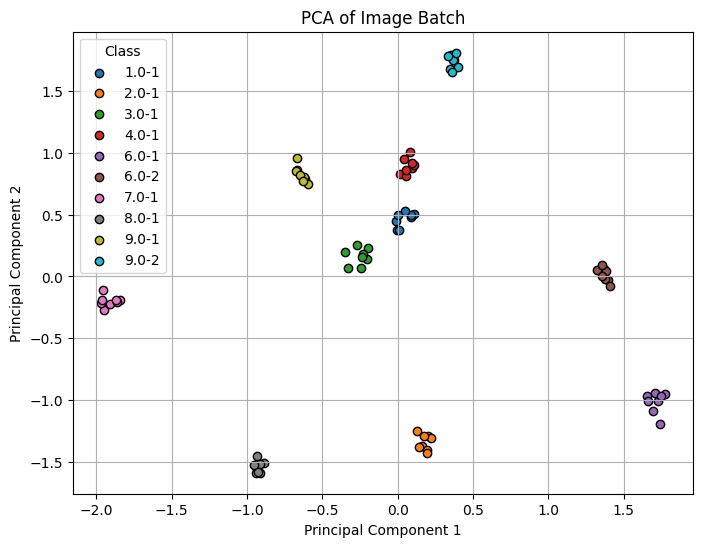

In [ ]:
fig_pca = pL.plot_pca(pca_predictions, subset_targets, n_rows=10, n_cols=8)

In [5]:
import src.models.pigvae_auto_module as pam

In [ ]:
import yaml

with open(
    "/Users/tomasznocon/Documents/MIM/Repositories/Master thesis/immuvis/configs/model/model.yaml",
    "r",
) as f:
    cfg = yaml.safe_load(f)

In [ ]:
from types import SimpleNamespace

ga = SimpleNamespace(
    input_size=256,
    num_heads=4,
    num_layers=4,
    emb_dim=64,
    vae=False,
    dropout=0.1,
    encoder=SimpleNamespace(
        graph_encoder_hidden_dim=256,
        num_node_features=16,
        num_edge_features=0,
        graph_encoder_num_heads=4,
        graph_encoder_ppf_hidden_dim=1024,
        graph_encoder_num_layers=4,
        emb_dim=64,
        dropout=0.0,
        grid_size=6,
    ),
    decoder=SimpleNamespace(
        graph_decoder_hidden_dim=256,
        graph_decoder_pos_emb_dim=256,
        graph_decoder_num_heads=4,
        graph_decoder_ppf_hidden_dim=1024,
        graph_decoder_num_layers=4,
        dropout=0.1,
        head_dim=64,
        num_node_features=16,
        num_edge_features=0,
    ),
    bottle_neck_encoder=SimpleNamespace(
        graph_encoder_hidden_dim=256,
        emb_dim=64,
        vae=False,
        activation="silu",
        num_permutations=8,
    ),
    bottle_neck_decoder=SimpleNamespace(emb_dim=64, graph_decoder_hidden_dim=256),
    property_predictor=SimpleNamespace(
        emb_dim=64, property_predictor_hidden_dim=256, num_properties=1
    ),
    permuter=SimpleNamespace(
        graph_decoder_hidden_dim=256,
        graph_decoder_num_heads=4,
        graph_decoder_ppf_hidden_dim=1024,
        dropout=0.1,
        num_permutations=8,
        grid_size=6,
        break_symmetry_scale=0.05,
        emb_dim=64,
        turn_off=False,
        use_ce=False,
        head_dim=64,
        num_node_features=16,
    ),
)

ts = SimpleNamespace(initial_tau=1.0, final_tau=0.3, num_epochs=500, start_epoch=1)

ews = SimpleNamespace(
    initial_weight=0.2,
    final_weight=0.05,
    mode="exponential",
    num_epochs=500,
    start_epoch=1,
)

c = SimpleNamespace(
    kld_loss_scale=0.001,
    perm_loss_scale=0.7,
    contrastive_loss_scale=0.01,
    temperature=0.07,
    num_aug_per_sample=8,
    vae=False,
)

o = SimpleNamespace(_partial_=True, lr=1e-4, weight_decay=0.0)

s = SimpleNamespace(
    batch_size=64,  # it might be acctully batch_size * 8
    warmup=0.1,
)

com = SimpleNamespace(compile=False)

In [ ]:
from src.models.components.modules import GraphAE
from src.models.components.model import Critic
from src.models.components.schedulers import (
    TemperatureScheduler,
    EntropyWeightScheduler,
)
from torch.optim import Adam
from src.models.components.warmups import get_cosine_schedule_with_warmup


graph_ae = GraphAE(ga)
critic = Critic(c)
temperature_scheduler = TemperatureScheduler(ts)
entropy_weight_scheduler = EntropyWeightScheduler(ews)
adam = lambda params: torch.optim.Adam(params, lr=1e-3)


model = pam.PLGraphAE(
    graph_ae, critic, temperature_scheduler, entropy_weight_scheduler, adam, s, False
)

/Users/tomasznocon/Documents/MIM/Repositories/Master thesis/immuvis/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'critic' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['critic'])`.
/Users/tomasznocon/Documents/MIM/Repositories/Master thesis/immuvis/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'temperature_scheduler' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['temperature_scheduler'])`.
/Users/tomasznocon/Documents/MIM/Repositories/Master thesis/immuvis/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'entropy_weight_scheduler' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparame

In [6]:
model = pam.PLGraphAE.load_from_checkpoint('/Users/tomasznocon/Documents/MIM/Repositories/Master thesis/immuvis/logs/train/runs/2025-08-02_19-54-19/checkpoints/epoch_160.ckpt')

/Users/tomasznocon/Documents/MIM/Repositories/Master thesis/immuvis/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'critic' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['critic'])`.
/Users/tomasznocon/Documents/MIM/Repositories/Master thesis/immuvis/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'temperature_scheduler' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['temperature_scheduler'])`.
/Users/tomasznocon/Documents/MIM/Repositories/Master thesis/immuvis/.venv/lib/python3.12/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'entropy_weight_scheduler' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparame

In [7]:
model = model.to('cpu')

In [ ]:
# el.node_features = el.node_features.to('mps')
# el.edge_features = el.edge_features.to('mps')
# el.properties = el.properties.to('mps')
# el.mask = el.mask.to('mps')
# el.argsort_augmented_features = el.argsort_augmented_features.to('mps')
# el.perms = el.perms.to('mps')
# el.y = el.y.to('mps')

In [10]:
model.eval()
with torch.no_grad():
    out = model.graph_ae.encoder(el.node_features, el.edge_features, el.mask)

    # out = model.graph_ae.encode(
    #     el
    # )

    # out = model.graph_ae(
    #     el,  True, 1.0
    # )

    # all_out = model(el, True, 1.0)

    graph_emb, graph_pred, soft_probs, perm, mu, logvar = model(
            graph=el, training=True, tau=1.0
        )

    # out = model.critic.evaluate(
    #         graph_emb=graph_emb,
    #         graph_true=el,
    #         graph_pred=graph_pred,
    #         soft_probs=soft_probs,
    #         perm=perm,
    #         beta=0.0,
    #         mu=mu,
    #         logvar=logvar,
    #         prefix="val",
        
    # )

(array([[ 0.,  0.,  0., ...,  8.,  1.,  1.],
        [ 0.,  0.,  0., ..., 15.,  1.,  0.],
        [ 0.,  0.,  0., ...,  6.,  5.,  2.],
        ...,
        [ 0.,  0.,  0., ...,  5.,  4.,  0.],
        [ 0.,  0.,  0., ..., 10.,  5.,  4.],
        [ 0.,  0.,  0., ...,  5.,  1.,  0.]], shape=(256, 10)),
 array([-11.95947456, -10.14221191,  -8.32495022,  -6.50768757,
         -4.6904254 ,  -2.87316322,  -1.05590057,   0.76136112,
          2.57862377,   4.39588547,   6.21314764]),
 <a list of 256 BarContainer objects>)

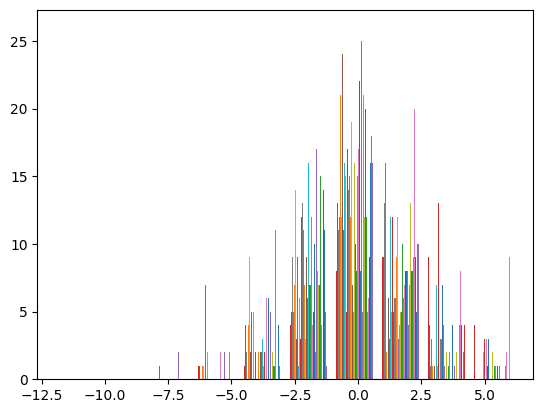

In [22]:
import matplotlib.pyplot as plt

plt.hist(out[1][1])

In [30]:
nums = [2, 7, 9, 3, 1]
n = len(nums)

dp = [0] * (n + 1)
dp[1] = nums[0]

for i in range(2, n + 1):
    dp[i] = max(dp[i - 1], nums[i - 1] + dp[i - 2])

In [ ]:
dp

[0, 2, 7, 11, 11, 12]

In [38]:
max([1, 2], [3, 4]).pop(0)

3

In [36]:
a = [2, 4] 
b = [6, 1]

def merge(a, b):
    return [max(a, b).pop(0) for _ in a+b]


merge(a, b)



[6, 2, 4, 1]

In [25]:
out

(tensor([[ 2.0006, -1.8422, -2.8000,  ...,  1.8808, -3.6406, -0.6818],
         [ 0.2879, -1.8751, -3.5957,  ..., -0.2283, -2.5915, -0.7602],
         [ 1.5987, -3.6110, -2.9288,  ...,  0.8165, -2.3419, -0.5349],
         ...,
         [ 0.8715, -2.2069, -2.6956,  ..., -0.7482, -1.9007, -1.4645],
         [-0.2844, -2.1801, -4.6150,  ...,  0.1774, -2.2381,  1.0840],
         [ 0.1145, -2.8701, -4.8028,  ..., -0.4902, -2.6353,  1.1045]]),
 tensor([[[-2.6775e+00,  3.1317e+00,  9.4427e-01,  ..., -3.2652e+00,
            8.9517e-01, -1.3132e+00],
          [-2.0780e+00,  5.9891e-02, -3.8581e+00,  ..., -3.3501e+00,
            1.5069e-01, -6.8032e-01],
          [ 1.8287e+00, -8.5579e-01, -3.1181e+00,  ...,  1.2706e+00,
            1.4432e+00, -1.1375e+00],
          ...,
          [ 1.6583e+00,  3.0544e+00, -3.1023e-01,  ...,  3.1254e+00,
            5.4449e+00,  8.5288e-01],
          [-3.0594e-01,  2.0645e+00,  2.2810e+00,  ...,  9.8821e-02,
            5.6577e+00, -1.5137e-01],
        

In [ ]:
all_out[0][0]

tensor([ 1.7599, -3.0947, -0.3770,  0.2691,  0.6374, -1.5249,  1.6893, -2.8880,
        -1.0497, -1.6275, -0.0665,  0.9897,  0.2851, -0.5804, -1.6186, -0.6232,
         1.3066, -2.1492, -0.1993, -0.3291, -0.1669,  1.5432,  0.1194, -0.4588,
         0.2895, -0.1807, -0.5389, -1.4263, -2.2342,  0.8441, -0.9645,  0.3349,
        -0.7688,  1.2462,  0.2720,  1.9502, -1.0002, -0.1579, -0.2797,  0.5402,
         1.6183,  2.3526,  1.1959,  0.8645,  0.9599, -1.4596,  0.9312,  0.5867,
        -0.5978, -0.6680,  0.8029, -0.2563, -2.1233, -1.4537,  0.0920, -0.3283,
        -1.0059, -0.1320,  0.7106,  1.2877,  0.2649, -1.9521, -0.2909, -0.0878])

In [ ]:
all_out[0][64]

tensor([ 1.7599, -3.0947, -0.3770,  0.2691,  0.6374, -1.5249,  1.6893, -2.8880,
        -1.0497, -1.6275, -0.0665,  0.9897,  0.2851, -0.5804, -1.6186, -0.6232,
         1.3066, -2.1492, -0.1993, -0.3291, -0.1669,  1.5432,  0.1194, -0.4588,
         0.2895, -0.1807, -0.5389, -1.4263, -2.2342,  0.8441, -0.9645,  0.3349,
        -0.7688,  1.2462,  0.2720,  1.9502, -1.0002, -0.1579, -0.2797,  0.5402,
         1.6183,  2.3526,  1.1959,  0.8645,  0.9599, -1.4596,  0.9312,  0.5867,
        -0.5978, -0.6680,  0.8029, -0.2563, -2.1233, -1.4537,  0.0920, -0.3283,
        -1.0059, -0.1320,  0.7106,  1.2877,  0.2649, -1.9521, -0.2909, -0.0878])

In [ ]:
torch.sort(out[1][0], dim = 0)

torch.return_types.sort(
values=tensor([[-2.6775, -3.8979, -5.2102,  ..., -3.7503, -2.5004, -3.9115],
        [-2.4213, -2.1233, -4.4562,  ..., -3.5575, -2.1720, -3.7506],
        [-2.0780, -2.1115, -3.8581,  ..., -3.3501, -2.1719, -3.6223],
        ...,
        [ 3.5096,  2.4926,  3.2583,  ...,  4.7868,  5.3568,  1.7953],
        [ 3.6714,  3.0544,  3.5901,  ...,  5.0698,  5.4449,  1.8997],
        [ 4.9664,  3.1317,  3.8607,  ...,  5.4392,  5.6577,  3.1900]]),
indices=tensor([[ 0, 22, 15,  ..., 28, 19,  8],
        [35, 27, 14,  ...,  1, 15,  7],
        [ 6, 16,  6,  ...,  6, 14, 28],
        ...,
        [18, 17, 28,  ..., 17, 34, 30],
        [ 3, 23, 35,  ..., 13, 23, 20],
        [ 8,  0, 34,  ..., 18, 29, 17]]))

In [ ]:
torch.sort(out[1][64], dim = 0)

torch.return_types.sort(
values=tensor([[-2.6775, -3.8979, -5.2102,  ..., -3.7503, -2.5004, -3.9115],
        [-2.4213, -2.1233, -4.4562,  ..., -3.5575, -2.1720, -3.7506],
        [-2.0780, -2.1115, -3.8581,  ..., -3.3501, -2.1719, -3.6223],
        ...,
        [ 3.5096,  2.4926,  3.2583,  ...,  4.7868,  5.3568,  1.7953],
        [ 3.6714,  3.0544,  3.5901,  ...,  5.0698,  5.4449,  1.8997],
        [ 4.9664,  3.1317,  3.8607,  ...,  5.4392,  5.6577,  3.1900]]),
indices=tensor([[30, 16, 21,  ..., 10, 13, 26],
        [ 5,  9, 20,  ..., 31, 21, 25],
        [24, 22, 24,  ..., 24, 20, 10],
        ...,
        [12, 23, 10,  ..., 23,  4,  0],
        [33, 17,  5,  ..., 19, 17, 14],
        [26, 30,  4,  ..., 12, 11, 23]]))

In [ ]:
torch.sort(out[0][0])

torch.return_types.sort(
values=tensor([-2.7763, -2.5027, -2.2761, -2.0085, -1.9637, -1.6213, -1.6149, -1.6140,
        -1.5532, -1.5298, -1.4199, -1.3468, -1.2810, -1.1082, -0.9067, -0.7831,
        -0.6718, -0.6591, -0.6389, -0.6280, -0.6164, -0.5662, -0.5410, -0.4950,
        -0.4365, -0.3709, -0.3467, -0.3106, -0.2987, -0.2635, -0.2209, -0.2165,
        -0.1929, -0.0645, -0.0255, -0.0073,  0.0771,  0.0894,  0.1066,  0.1525,
         0.1871,  0.2199,  0.2207,  0.2558,  0.2580,  0.3285,  0.3883,  0.3954,
         0.4397,  0.5460,  0.5758,  0.7062,  0.7679,  0.8217,  0.8541,  1.1856,
         1.3409,  1.3985,  1.5737,  1.6215,  2.1301,  2.4543,  3.0574,  3.7902]),
indices=tensor([63, 27,  7, 32, 28, 39, 48, 10, 52, 16, 17, 44, 25,  2, 55, 24,  4, 46,
         1, 40, 54, 18,  9, 36,  5, 13, 12, 37, 31,  8, 20, 62, 26, 57, 19, 38,
        47, 51, 23,  3, 61, 45, 50, 11, 22,  0, 15, 35, 53, 56, 42, 29, 21, 43,
         6, 59, 58, 14, 33, 30, 49, 34, 60, 41]))

In [ ]:
torch.sort(out[0][0])

In [ ]:
torch.sort(out[0][64])

torch.return_types.sort(
values=tensor([-3.0470, -2.8004, -2.0287, -1.7696, -1.6568, -1.6434, -1.6081, -1.5075,
        -1.5001, -1.4358, -1.4115, -1.3516, -0.9710, -0.9658, -0.8896, -0.7662,
        -0.7493, -0.7028, -0.6910, -0.6608, -0.6027, -0.5839, -0.5513, -0.4419,
        -0.3903, -0.3313, -0.2950, -0.2324, -0.1310, -0.0970, -0.0766, -0.0672,
         0.0038,  0.0333,  0.0366,  0.0385,  0.0512,  0.0758,  0.2341,  0.2794,
         0.2838,  0.3068,  0.3217,  0.3274,  0.3354,  0.3839,  0.4002,  0.4005,
         0.4134,  0.4311,  0.4358,  0.4798,  0.5995,  0.7418,  1.2077,  1.3570,
         1.3825,  1.6094,  1.6142,  2.1103,  2.2878,  2.3487,  3.0444,  3.1459]),
indices=tensor([ 7, 63, 32, 28, 10, 39, 48, 16, 52, 25, 17, 44,  2, 27, 55,  1, 24,  9,
        36, 46, 54, 13, 40, 12,  8,  5, 62, 18, 31, 19, 20, 38, 23, 37, 26, 47,
        51, 57,  3, 11, 22, 50,  4, 45, 15, 61, 35, 43, 42, 53, 56,  0, 29, 21,
        59, 14, 58, 30, 33, 49,  6, 34, 60, 41]))

In [ ]:
all_out[0][0]

tensor([ 0.8504, -0.8735,  0.2076,  0.0115,  0.4299,  1.0385,  1.9854, -3.1008,
         0.1320,  0.0701,  1.1475,  2.3862,  0.4128,  0.0276, -0.5558,  0.8439,
         0.3482, -1.7985,  0.0070,  0.4986, -0.0532, -0.1450,  0.2081,  2.9432,
         0.0288, -0.8678, -0.2529, -1.0072, -0.4112, -1.3904, -1.1413, -0.3528,
        -0.3361,  1.9691, -0.7228,  0.6032, -0.2882,  0.5107,  2.4000,  0.7606,
        -0.5336,  3.2759,  1.1812,  0.4693, -0.2271,  0.7636, -0.6012, -1.2495,
        -1.2416,  0.6515, -0.5477, -0.4067,  0.7912,  0.4474,  0.6477, -1.5612,
        -1.0951, -0.6652,  1.2195, -0.0411, -1.1594, -0.3582, -0.4757, -0.3598])

In [ ]:
all_out[0][64]

tensor([ 0.8773, -0.9209,  0.2545,  0.0775,  0.4721,  1.0984,  2.1187, -3.0571,
         0.1182, -0.0319,  1.1565,  2.3463,  0.4222, -0.0995, -0.6772,  0.7792,
         0.4136, -1.7874, -0.1240,  0.3885,  0.0869, -0.1844,  0.2299,  2.9312,
        -0.0162, -0.8999, -0.2547, -1.0434, -0.3357, -1.4698, -1.0975, -0.2586,
        -0.3095,  1.9955, -0.7517,  0.5807, -0.3362,  0.3451,  2.3243,  0.7151,
        -0.4286,  3.2218,  1.1534,  0.4261, -0.2215,  0.7312, -0.5729, -1.1823,
        -1.2020,  0.6720, -0.4755, -0.3725,  0.7920,  0.4184,  0.6045, -1.5056,
        -1.1600, -0.5894,  1.1928, -0.0464, -1.1798, -0.2925, -0.5601, -0.3591])

In [ ]:
for i in range(64):
    for j in range(8):
        are_close = torch.allclose(out[0][i], out[0][i + j*64], rtol=1e-4, atol=1e-5)
        if not are_close:
            print(are_close)

In [ ]:
w = nn.Linear(256, 2 * 64)
activation = torch.nn.SiLU()
x = w(activation(out[0]))

for i in range(64):
    for j in range(8):
        are_close = torch.allclose(x[i], x[i + j*64], rtol=1e-4, atol=1e-5)
        if not are_close:
            print(are_close)

In [ ]:
batch_size = x.shape[0] // 8
mu = x[:, : 64]
logvar = x[:, 64 :]
std = torch.exp(0.5 * logvar)
batch_std = std[:batch_size, :]
batch_eps = torch.randn_like(batch_std)
eps = (
    batch_eps.unsqueeze(0)
    .repeat(8, 1, 1)
    .view(-1, batch_eps.shape[1])
)
x = mu + eps * std

In [ ]:
x[0]

tensor([-0.0048, -0.3540,  1.3578,  1.1565,  1.0556, -0.8566, -2.0298,  0.0099,
         0.9634,  2.7854,  1.4013, -1.4376,  0.8235, -1.5745,  0.5088,  0.8406,
        -1.0292,  1.2263,  2.3306, -0.7596, -0.7019,  2.0023, -2.4119,  0.0992,
        -1.9694,  0.2704,  0.3635,  0.3781,  0.1245, -0.6079, -0.0794, -1.1020,
        -0.8012, -1.1680, -0.1965, -0.4686,  0.3207,  0.0709,  2.1468,  0.8429,
        -0.8940,  0.7338, -0.5496,  1.2106, -0.1407, -0.7945, -0.2326, -1.2931,
         0.5669,  0.1810, -2.2444,  1.1015,  0.7312, -1.0493,  0.3569, -0.0736,
        -0.1198, -1.4253,  0.0922, -0.1015, -0.1580,  0.4999,  2.0006, -0.4506],
       grad_fn=<SelectBackward0>)

In [ ]:
x[64]

tensor([-0.0048, -0.3540,  1.3578,  1.1565,  1.0556, -0.8566, -2.0298,  0.0099,
         0.9634,  2.7854,  1.4013, -1.4376,  0.8235, -1.5745,  0.5088,  0.8406,
        -1.0292,  1.2263,  2.3306, -0.7596, -0.7019,  2.0023, -2.4119,  0.0992,
        -1.9694,  0.2704,  0.3635,  0.3781,  0.1245, -0.6079, -0.0794, -1.1020,
        -0.8012, -1.1680, -0.1965, -0.4686,  0.3207,  0.0709,  2.1469,  0.8429,
        -0.8940,  0.7338, -0.5496,  1.2106, -0.1407, -0.7945, -0.2326, -1.2931,
         0.5669,  0.1810, -2.2444,  1.1015,  0.7312, -1.0493,  0.3569, -0.0736,
        -0.1198, -1.4253,  0.0922, -0.1015, -0.1580,  0.4999,  2.0006, -0.4506],
       grad_fn=<SelectBackward0>)

In [ ]:
for i in range(64):
    for j in range(8):
        are_close = torch.allclose(x[i], x[i + j*64], rtol=1e-4, atol=1e-5)
        if not are_close:
            print(are_close)

In [ ]:
mu = x[:, :64]
logvar = x[:, 64:]
std = torch.exp(0.5 * logvar)
# x = mu + eps * std

In [ ]:
batch_size = 64
batch_std = std[:64, :]
eps = torch.randn_like(batch_std)
res = eps.unsqueeze(0).repeat(8, 1, 1).view(-1, eps.shape[1])
x = mu + res * std

In [ ]:
x[0]

tensor([ 0.6186, -0.8367, -1.2407,  1.1064, -0.7936, -0.5540, -0.1215,  0.4179,
         0.1897, -0.0464, -0.0874, -1.4688,  0.7813, -0.2001, -0.7594, -0.3958,
         0.6980, -1.9880,  0.6129,  1.1807, -1.9021,  1.2580, -0.9524,  0.0316,
         0.9501,  1.6222, -1.1098,  0.2279, -1.4309, -0.3141, -0.3799, -0.4482,
        -0.2760,  0.7454,  2.3805, -0.0184, -1.2057, -0.5501, -0.0857, -0.3420,
        -0.5590,  0.0540,  0.2094, -1.3641,  0.9157,  0.3869, -0.7734, -0.3207,
        -0.9633, -0.1428,  1.7206,  1.5265,  0.2084, -2.5524, -0.5990,  2.6706,
         0.1410,  0.4475,  0.0768, -0.6425, -0.7391,  0.1094,  0.6124, -1.7267],
       grad_fn=<SelectBackward0>)

In [ ]:
x[64]

tensor([ 0.6186, -0.8367, -1.2407,  1.1064, -0.7936, -0.5540, -0.1215,  0.4179,
         0.1897, -0.0464, -0.0874, -1.4688,  0.7813, -0.2001, -0.7594, -0.3958,
         0.6980, -1.9880,  0.6129,  1.1807, -1.9021,  1.2580, -0.9524,  0.0316,
         0.9501,  1.6222, -1.1098,  0.2279, -1.4309, -0.3141, -0.3799, -0.4482,
        -0.2760,  0.7454,  2.3805, -0.0184, -1.2057, -0.5501, -0.0857, -0.3420,
        -0.5590,  0.0540,  0.2094, -1.3641,  0.9157,  0.3869, -0.7734, -0.3207,
        -0.9633, -0.1428,  1.7206,  1.5265,  0.2084, -2.5524, -0.5990,  2.6706,
         0.1410,  0.4475,  0.0768, -0.6425, -0.7391,  0.1094,  0.6124, -1.7267],
       grad_fn=<SelectBackward0>)

In [ ]:
model.eval()
with torch.no_grad():
    out = model(el, True, 1.0)

In [ ]:
for i in range(64):
    for j in range(8):
        are_close = torch.allclose(out[0][i], out[0][i + j * 64], rtol=1e-4, atol=1e-5)
        if not are_close:
            print(are_close)

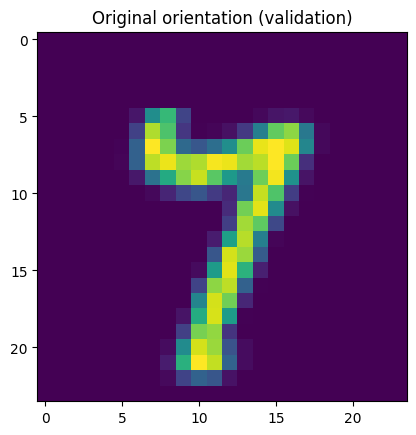

In [ ]:
# The first augmentation (index 0) should be the original orientation
r_orig = restore_tensor(res[129], 1, 1, 24, 24, 4)
plt.figure()
plt.imshow(r_orig.squeeze())
plt.title("Original orientation (validation)")
plt.show()

In [112]:
prefix = [0, 1, 1, 2, 2, 2, 2, 2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 9, 9, 10, 10, 11, 11, 11, 12]


def binary_search(arr, target):
    i, j = 0, len(arr) - 1
    while i <= j:
        mid = (i + j) // 2
        if arr[mid] == target:
            return mid
        elif arr[mid] < target:
            i = mid + 1
        else:
            j = mid - 1
    return -1

def binary_search_variant(arr, target):
    i, j = 0, len(arr)
    while i < j:
        mid = (i + j) // 2
        if arr[mid] < target:
            i = mid + 1
        else:
            j = mid
    return i

def find_last_leq(arr, target):
    i, j = 0, len(arr)
    while i < j:
        mid = (i + j) // 2
        if arr[mid] <= target:
            i = mid + 1  # move right to look for bigger index
        else:
            j = mid       # move left
    return i - 1


def find_first_leq(arr, target):
    i, j = 0, len(arr)
    while i < j:
        mid = (i + j) // 2
        if arr[mid] < target:
            i = mid + 1  # move right to look for bigger index
        else:
            j = mid       # move left
    return i

def find_last_leq_2(arr, target):
    i, j = 0, len(arr)
    while i < j:
        mid = (i + j + 1) // 2
        if arr[mid] <= target:
            i = mid
        else:
            j = mid - 1
    
    return i

In [117]:
a = [10, 11, 19, 39, 40]

find_first_leq(a, 18)

2

In [103]:
binary_search(prefix, 4)
binary_search_variant(prefix, 4)
find_last_leq(prefix, 4)

16

In [104]:
find_last_leq_2(prefix, 4)

16

In [37]:
i = 2
j = 33
e = -1
while i <= j:
    m = (i + j + 1) // 2
    if prefix[m] == prefix[m + 1]:
        e = m
    i = m + 1

e

32

In [ ]:
class SimplePermuter(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.turn_off = True
        self.scoring_fc = torch.nn.Linear(256, 8)
        # self.graph_transformer = Transformer(
        #     hidden_dim=hparams.graph_decoder_hidden_dim,
        #     num_heads=hparams.graph_decoder_num_heads,
        #     ppf_hidden_dim=hparams.graph_decoder_ppf_hidden_dim,
        #     num_layers=2,
        #     dropout=hparams.dropout,
        #     rope=LLamaRotaryEmbedding(hparams.head_dim),
        # )
        # self.spectral_embeddings = SklearnSpectralEmbedding(
        #     hparams.num_node_features,
        #     hparams.graph_decoder_hidden_dim,
        #     hparams.grid_size,
        # )
        self.perm_context = torch.nn.Linear(8, 64)
        predefined_permutations = self.create_predefine_permutations(6)
        # Predefined permutation matrices (B, num_permutations, N, N)
        self.register_buffer("predefined_permutations", predefined_permutations)
        self.break_symmetry_scale = 0.01

    def forward(
        self,
        node_features: torch.Tensor,
        tau: float,
        mask: torch.Tensor,
        hard: bool = False,
    ):
        # Add noise to break symmetry

        if self.turn_off:
            return None, None, None

        node_features = (
            node_features + torch.randn_like(node_features) * self.break_symmetry_scale
        )
        node_features = self.spectral_embeddings(node_features)
        node_features = self.graph_transformer(
            node_features, mask=None, is_encoder=False
        )
        # Score each permutation option
        scores = self.scoring_fc(node_features).mean(dim=1)  # (B, num_permutations)
        context = self.perm_context(scores)

        # Softmax over scores to get probabilities for each permutation
        soft_probs = torch.softmax(scores / tau, dim=-1)  # (B, num_permutations)
        # Hard selection using Gumbel-Softmax (discrete but differentiable)
        one_hot = torch.zeros_like(soft_probs)
        one_hot.scatter_(1, soft_probs.argmax(dim=-1, keepdim=True), 1.0)
        probs = (one_hot - soft_probs).detach() + soft_probs

        # Combine predefined permutations with the probabilities
        # Shape: (B, N, N) = (B, num_permutations, N, N) * (B, num_permutations, 1, 1)
        # Expand probs to (B, num_permutations, 1, 1) to match (num_permutations, N, N)
        probs = probs.unsqueeze(-1).unsqueeze(-1)  # (B, num_permutations, 1, 1)
        # Combine predefined permutations with probabilities
        # Shape: (B, N, N) = (B, num_permutations, 1, 1) * (num_permutations, N, N) -> sum over 8
        perm = torch.sum(probs * self.predefined_permutations, dim=1)  # (B, N, N)
        print(perm.shape)
        return perm, context, soft_probs

    def _permutation_matrix_90(self, n: int) -> torch.Tensor:
        indices = torch.arange(n * n).reshape(n, n)
        rotated_indices = indices.rot90(-1).reshape(-1)
        perm = torch.eye(n * n, dtype=torch.float32)[rotated_indices]
        return perm

    def _y_axis_reflection_matrix(self, n: int) -> torch.Tensor:
        indices = torch.arange(n * n).reshape(n, n)
        reflected_indices = indices.flip(1).reshape(-1)
        perm = torch.eye(n * n, dtype=torch.float32)[reflected_indices]
        return perm

    def create_predefine_permutations(self, n: int) -> torch.Tensor:
        perm = torch.eye(n * n, dtype=torch.float32)
        perm_90 = self._permutation_matrix_90(n)
        perm_180 = torch.matmul(perm_90, perm_90)
        perm_270 = torch.matmul(perm_180, perm_90)

        perm_y_reflection = self._y_axis_reflection_matrix(n)
        perm_y_reflection_90 = torch.matmul(perm_y_reflection, perm_90)
        perm_y_reflection_180 = torch.matmul(perm_y_reflection, perm_180)
        perm_y_reflection_270 = torch.matmul(perm_y_reflection, perm_270)

        # TODO: If I shuffle the train set with every epoch can I have fix this list if I have no labels?
        permutations = torch.stack(
            [
                perm,
                perm_90,
                perm_180,
                perm_270,
                perm_y_reflection,
                perm_y_reflection_90,
                perm_y_reflection_180,
                perm_y_reflection_270,
            ]
        )
        return permutations

    @staticmethod
    def permute_node_features(
        node_features: torch.Tensor, perm: torch.Tensor
    ) -> torch.Tensor:
        """Apply the permutation to node features."""
        return torch.matmul(perm, node_features)

In [ ]:
p = SimplePermuter()
perms = p.predefined_permutations

tensor([[False,  True,  True,  ...,  True,  True,  True],
        [ True, False,  True,  ...,  True,  True,  True],
        [ True,  True, False,  ...,  True,  True,  True],
        ...,
        [ True,  True,  True,  ..., False,  True,  True],
        [ True,  True,  True,  ...,  True, False,  True],
        [ True,  True,  True,  ...,  True,  True, False]])

In [ ]:
import torch
from typing import Tuple, Optional, Any
from torch.nn import Linear, LayerNorm, Dropout
from torch.nn.functional import pad

# from src.models.components.custom_graph_transformer import Transformer
from src.models.components.llama_graph_transformer import Transformer
from src.models.components.emdeddings import PositionalEncoding
from src.data.components.graphs_datamodules import DenseGraphBatch
from src.models.components.spectral_embeddings import SklearnSpectralEmbedding
from src.models.components.rotary_embedding import LLamaRotaryEmbedding

from omegaconf import DictConfig

In [ ]:
class GraphEncoder(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.projection_in = Linear(16, 256)

        self.graph_transformer = Transformer(
            hidden_dim=256,
            num_heads=4,
            ppf_hidden_dim=1024,
            num_layers=4,
            dropout=0.0,
        )
        self.fc_in = Linear(256, 256)
        self.layer_norm = LayerNorm(256)
        self.dropout = Dropout(0.0)

    def add_emb_node_and_feature(
        self,
        node_features: torch.Tensor,
        edge_features: torch.Tensor,
        mask: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        node_features = pad(node_features, (0, 0, 1, 0))
        mask = pad(mask, (1, 0), value=1)
        return node_features, edge_features, mask

    def init_message_matrix(
        self,
        node_features: torch.Tensor,
        edge_features: torch.Tensor,
        mask: torch.Tensor,
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        node_features, edge_features, mask = self.add_emb_node_and_feature(
            node_features, edge_features, mask
        )
        x = self.layer_norm(self.dropout(self.fc_in(node_features)))
        return x, mask  # edge_mask

    def read_out_message_matrix(
        self, x: torch.Tensor
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        node_features = x
        graph_emb, node_features = node_features[:, 0], node_features[:, 1:]
        return graph_emb, node_features

    def forward(
        self,
        node_features: torch.Tensor,
        edge_features: torch.Tensor,
        mask: torch.Tensor,
        device: str = "mps",
    ) -> Tuple[torch.Tensor, torch.Tensor]:
        node_features = node_features.to(device)
        node_features = self.projection_in(node_features)
        x, _ = self.init_message_matrix(node_features, edge_features, mask)
        x = self.graph_transformer(x, mask=None, is_encoder=True)
        graph_emb, node_features = self.read_out_message_matrix(x)
        return graph_emb, node_features

In [ ]:
encoder = GraphEncoder()
encoder.eval()
with torch.no_grad():
    out = encoder(el.node_features, el.edge_features, el.mask, device="cpu")

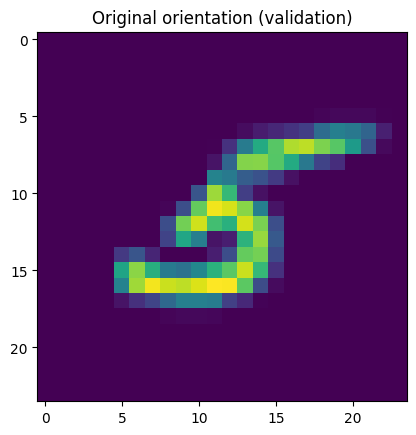

In [ ]:
# Try with validation data (no permutation)
val_imgs = data_val[0][0][0]
val_args = data_val[0][0][1]

# The first augmentation (index 0) should be the original orientation
r_orig = restore_tensor(val_imgs[0], 1, 1, 24, 24, 4)
plt.figure()
plt.imshow(r_orig.squeeze())
plt.title("Original orientation (validation)")
plt.show()

In [ ]:
x = torch.rand([1, 1, 8, 8])
# x = torch.tensor([[1, 2], [3, 4]])
x_rot = torch.rot90(x, k=-1, dims=[-2, -1])

In [ ]:
n = 2
grid = torch.arange(n * n).reshape(n, n)

In [ ]:
x = torch.tensor(
    [[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12], [13, 14, 15, 16]], dtype=torch.float32
)
x = x.unsqueeze(0).unsqueeze(0)
splitPatches = SplitPatches(2)
s = splitPatches(x)

In [ ]:
pa = PatchAugmentations(1.0, 4, 2)

ret, arg = pa(s)

In [ ]:
for i in range(7):
    print(restore_tensor(ret[i][:, arg[i], :], 1, 1, 4, 4, 2))

tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])
tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])
tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])
tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])
tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])
tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])
tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])


In [ ]:
c = s[:, torch.tensor([1, 3, 0, 2]), :]

i = torch.tensor([1, 3, 0, 2])
argsort = torch.argsort(i)
c[:, argsort, :]
argsort

tensor([2, 0, 3, 1])

In [ ]:
a = torch.arange(2 * 2).reshape(2, 2)

In [ ]:
splitPatches = SplitPatches(4)
s = splitPatches(x)
s_rot = splitPatches(x_rot)
s_bis = s[:, [2, 0, 3, 1], :]
projection_in = nn.Linear(16, 2)

IndexError: index 2 is out of bounds for dimension 0 with size 1

In [ ]:
import numpy as np
import torch
import math
import torch.nn as nn

# from torch.nn.attention import SDPBackend
from collections import OrderedDict

"""
adapted from https://github.com/jadore801120/attention-is-all-you-need-pytorch
"""


class Transformer(nn.Module):
    def __init__(self, hidden_dim, num_heads, ppf_hidden_dim, num_layers, dropout=0.1):
        super().__init__()
        self.num_layers = num_layers
        self.ppf_hidden_dim = ppf_hidden_dim  # TBDeleted
        # self.embedding_layer = EmbeddingLayer(
        #     config.vocab_size, config.d_model, config.max_len
        # )
        self.blocks = nn.ModuleList(
            [
                TransformerBlock(hidden_dim, num_heads, dropout)
                for _ in range(num_layers)
            ]
        )

        # self.head = nn.Linear(config.d_model, config.vocab_size, bias=False)

    def forward(self, x, mask):
        # output = self.embedding_layer(input_ids)

        for block in self.blocks:
            x = block(x, mask)

        output = x
        # output = self.head(output)
        return output

    def init_weights(self):
        for norm in (self.attention_norm, self.ffn_norm):
            norm.reset_parameters()
        self.attention.init_weights(self.weight_init_std)
        self.feed_forward.init_weights(self.weight_init_std)


class TransformerBlock(nn.Module):
    def __init__(self, hidden_dim, n_head, dropout):
        super().__init__()
        self.attention_layer = SelfAttention(n_head, hidden_dim, dropout)
        self.feed_forward_layer = FeedForward(hidden_dim, dropout)

    def forward(self, x, attention_mask):
        out_attention = self.attention_layer(x, attention_mask)
        x = x + out_attention

        out_feed_forward = self.feed_forward_layer(x)
        x = x + out_feed_forward
        return x


def FeedForward(hidden_size, dropout=0.1):
    return nn.Sequential(
        OrderedDict(
            [
                ("ff_layernorm", nn.LayerNorm(hidden_size)),
                (
                    "pre_relu",
                    nn.Linear(
                        hidden_size,
                        4 * hidden_size,
                        bias=True,
                    ),
                ),
                ("relu", nn.ReLU()),
                (
                    "post_relu",
                    nn.Linear(
                        4 * hidden_size,
                        hidden_size,
                        bias=True,
                    ),
                ),
                ("dropout", nn.Dropout(dropout)),
            ]
        )
    )


class SelfAttention(torch.nn.Module):
    def __init__(self, n_head, hidden_dim, dropout=0.1):
        super().__init__()

        self.n_head = n_head
        self.hidden_dim = hidden_dim

        self.layer_norm = nn.LayerNorm(hidden_dim)
        self.input_projection = nn.Linear(hidden_dim, 3 * hidden_dim, bias=False)
        self.output_projection = nn.Linear(hidden_dim, hidden_dim, bias=False)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask):
        # x: b x nn x nn x dv
        batch_size, num_nodes = x.size(0), x.size(1)
        x = self.layer_norm(x)
        projected = self.input_projection(x)

        device = x.device

        q_chunk, k_chunk, v_chunk = torch.chunk(projected, chunks=3, dim=-1)
        query = q_chunk.view(batch_size, num_nodes, num_nodes, self.n_head, -1).permute(
            0, 3, 1, 2, 4
        )
        key = k_chunk.view(batch_size, num_nodes, num_nodes, self.n_head, -1).permute(
            0, 3, 2, 1, 4
        )
        value = v_chunk.view(batch_size, num_nodes, num_nodes, self.n_head, -1).permute(
            0, 3, 2, 1, 4
        )

        attn_mask = mask
        # .masked_fill(
        #     torch.eye(num_nodes, num_nodes, device=device).bool(), 0
        # )
        attn_mask = attn_mask.unsqueeze(1).expand(-1, num_nodes, -1, -1)
        # attn_mask = attn_mask * (
        #     torch.eye(num_nodes, num_nodes, device=device) == 0
        # ).bool().unsqueeze(0).unsqueeze(-2).expand(-1, -1, num_nodes, -1)

        # with torch.nn.attention.sdpa_kernel(
        #     [
        #         SDPBackend.FLASH_ATTENTION,
        #         SDPBackend.EFFICIENT_ATTENTION,
        #         SDPBackend.MATH,
        #     ]
        # ):

        attention_output = scaled_dot_product_attention(
            query=query,
            key=key,
            value=value,
            attn_mask=attn_mask,
            is_causal=False,
        )
        attention_output = attention_output.permute(0, 2, 3, 1, 4).contiguous()
        output = self.output_projection(attention_output.transpose(1, 2).flatten(-2))
        output = self.dropout(output)
        return output


class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_hid, n_position=200):
        super(PositionalEncoding, self).__init__()

        # Not a parameter
        self.register_buffer(
            "pos_table", self._get_sinusoid_encoding_table(n_position, d_hid)
        )

    def _get_sinusoid_encoding_table(self, n_position, d_hid):
        """Sinusoid position encoding table"""
        # TODO: make it with torch instead of numpy

        def get_position_angle_vec(position):
            return [
                position / np.power(10000, 2 * (hid_j // 2) / d_hid)
                for hid_j in range(d_hid)
            ]

        sinusoid_table = np.array(
            [get_position_angle_vec(pos_i) for pos_i in range(n_position)]
        )
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

        return torch.FloatTensor(sinusoid_table).unsqueeze(0)

    def forward(self, batch_size, num_nodes):
        x = self.pos_table[:, :num_nodes].clone().detach()
        x = x.expand(batch_size, -1, -1)
        return x


class EmbeddingLayer(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_len):
        super(EmbeddingLayer, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(max_len, embed_dim)

    def forward(self, x):
        # x: (batch_size, seq_len)
        seq_len = x.size(1)
        positions = (
            torch.arange(seq_len, dtype=torch.long, device=x.device)
            .unsqueeze(0)
            .expand_as(x)
        )
        token_embeddings = self.token_embedding(x)
        position_embeddings = self.position_embedding(positions)
        embeddings = token_embeddings + position_embeddings
        return embeddings


# Efficient implementation equivalent to the following:
# https://pytorch.org/docs/stable/generated/torch.nn.functional.scaled_dot_product_attention.html
def scaled_dot_product_attention(
    query,
    key,
    value,
    attn_mask=None,
    dropout_p=0.0,
    is_causal=False,
    scale=None,
    enable_gqa=False,
) -> torch.Tensor:
    L, S = query.size(-2), key.size(-2)
    scale_factor = 1 / math.sqrt(query.size(-1)) if scale is None else scale
    attn_bias = torch.zeros(
        (*query.shape[:-2], L, S), dtype=query.dtype, device=query.device
    )
    if is_causal:
        assert attn_mask is None
        temp_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0)
        attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
        attn_bias.to(query.dtype)

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_bias.masked_fill_(attn_mask[0].logical_not(), float("-inf"))
        else:
            attn_bias = attn_mask + attn_bias

    if enable_gqa:
        key = key.repeat_interleave(query.size(-3) // key.size(-3), -3)
        value = value.repeat_interleave(query.size(-3) // value.size(-3), -3)

    attn_weight = query @ key.transpose(-2, -1) * scale_factor
    attn_weight += attn_bias
    attn_weight = torch.softmax(attn_weight, dim=-1)
    attn_weight = torch.dropout(attn_weight, dropout_p, train=True)
    return attn_weight @ value

In [ ]:
import torch
import torch.nn as nn
from types import SimpleNamespace
import torch.nn.functional as F


class EmbeddingLayer(nn.Module):
    def __init__(self, vocab_size, embed_dim, max_len):
        super(EmbeddingLayer, self).__init__()
        self.token_embedding = nn.Embedding(vocab_size, embed_dim)
        self.position_embedding = nn.Embedding(max_len, embed_dim)

    def forward(self, x):
        # x: (batch_size, seq_len)
        seq_len = x.size(1)
        positions = (
            torch.arange(seq_len, dtype=torch.long, device=x.device)
            .unsqueeze(0)
            .expand_as(x)
        )
        token_embeddings = self.token_embedding(x)
        position_embeddings = self.position_embedding(positions)
        embeddings = token_embeddings + position_embeddings
        return embeddings


class AttentionLayer(nn.Module):
    def __init__(
        self,
        dmodel,
        heads,
    ):
        super(AttentionLayer, self).__init__()

        self.ln = nn.LayerNorm(dmodel)

        self.heads = heads

        self.input_projection = nn.Linear(dmodel, 3 * dmodel, bias=False)

        self.output_projection = nn.Linear(dmodel, dmodel, bias=False)

    def forward(self, x, attention_mask):
        x = self.ln(x)

        projected = self.input_projection(x)

        batch, seq_len = x.shape[:-1]
        q_chunk, k_chunk, v_chunk = torch.chunk(projected, chunks=3, dim=-1)
        query = q_chunk.view(batch, seq_len, self.heads, -1).transpose(1, 2)
        key = k_chunk.view(batch, seq_len, self.heads, -1).transpose(1, 2)
        value = v_chunk.view(batch, seq_len, self.heads, -1).transpose(1, 2)

        # with torch.nn.attention.sdpa_kernel(
        #     [
        #         SDPBackend.FLASH_ATTENTION,
        #         SDPBackend.EFFICIENT_ATTENTION,
        #         SDPBackend.MATH,
        #     ]
        # ):
        attention_output = F.scaled_dot_product_attention(
            query=query,
            key=key,
            value=value,
            attn_mask=attention_mask,
            is_causal=True,
        )

        output = self.output_projection(attention_output.transpose(1, 2).flatten(-2))

        return output


def FeedForward(
    dmodel,
):
    return nn.Sequential(
        OrderedDict(
            [
                ("ff_layernorm", nn.LayerNorm(dmodel)),
                (
                    "pre_relu",
                    nn.Linear(
                        dmodel,
                        4 * dmodel,
                        bias=True,
                    ),
                ),
                ("relu", nn.ReLU()),
                (
                    "post_relu",
                    nn.Linear(
                        4 * dmodel,
                        dmodel,
                        bias=True,
                    ),
                ),
            ]
        )
    )


class Block(nn.Module):
    def __init__(
        self,
        dmodel,
        heads,
    ):
        super().__init__()
        self.attention_layer = AttentionLayer(dmodel, heads)
        self.feed_forward_layer = FeedForward(dmodel)

    def forward(self, x, attention_mask):
        out_attention = self.attention_layer(x, attention_mask)
        x = x + out_attention

        out_feed_forward = self.feed_forward_layer(x)
        x = x + out_feed_forward
        return x


class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding_layer = EmbeddingLayer(
            config.vocab_size, config.d_model, config.max_len
        )
        self.blocks = nn.ModuleList(
            [Block(config.d_model, config.num_heads) for _ in range(config.num_layers)]
        )

        self.head = nn.Linear(config.d_model, config.vocab_size, bias=False)

    def forward(self, input_ids, attention_mask=None):
        output = self.embedding_layer(input_ids)

        for block in self.blocks:
            output = block(output, attention_mask)

        output = self.head(output)
        return output


def main():
    config = SimpleNamespace(
        d_model=256,
        num_heads=4,
        num_layers=4,
        learning_rate=1e-4,
        dropout=0.0,
        seq_length=256,
        batch_size=64,
    )

In [ ]:
blocks = nn.ModuleList([Block(256, 4) for _ in range(4)])

In [ ]:
x = torch.randn(64, 256, 256)
blocks[0](x, None).shape

torch.Size([64, 256, 256])

In [ ]:
blocks = nn.ModuleList([TransformerBlock(32, 4, 0.1) for _ in range(6)])

In [ ]:
x = torch.randn(1, 10, 10, 32)
mask = torch.ones(1, 10, 10)
o = blocks[0](x, mask)
o.shape

torch.Size([1, 10, 10, 32])

In [ ]:
t = Transformer(
    hidden_dim=32,
    num_heads=4,
    ppf_hidden_dim=128,
    num_layers=6,
    dropout=0.1,
)

In [ ]:
out = t(x, torch.ones(1, 10, 10))

In [ ]:
out.shape

torch.Size([1, 10, 10, 32])

In [ ]:
import torch
from torch.nn.functional import pad

In [ ]:
import torch
import torch.nn as nn
import networkx as nx
import matplotlib.pyplot as plt

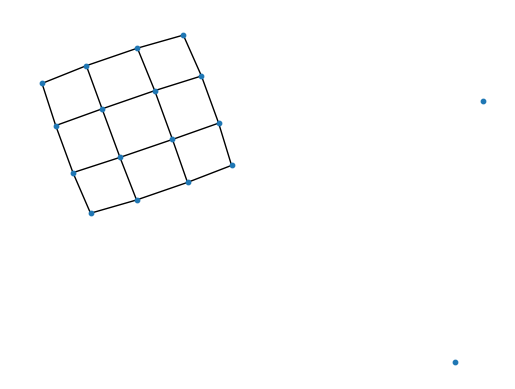

In [ ]:
options = {"node_color": "C0", "node_size": 10}

G = nx.grid_2d_graph(4, 4)
G.add_nodes_from([i for i in range(4, 6)])
plt.subplot()
nx.draw(G, **options)

In [ ]:
node_features = torch.tensor(
    [
        [[1.0, 2.0], [3.0, 4.0], [5.0, 6.0], [7.0, 8.0]],
        [[7.0, 8.0], [9.0, 10.0], [11.0, 12.0], [13.0, 14.0]],
    ]
)

mask = torch.tensor(
    [
        [True, True, True, True],
        [True, True, True, True],
    ]
)
node_features.shape

node_features = pad(node_features, (0, 0, 1, 0))
mask = pad(mask, (1, 0), value=1)

edge_mask = mask.unsqueeze(1) * mask.unsqueeze(2)

mask.unsqueeze(1).expand(-1, 5, -1).shape

torch.Size([2, 4, 2])

In [ ]:
node_features = pad(node_features, (0, 0, 1, 0))
mask = pad(mask, (1, 0), value=1)

In [ ]:
edge_mask = mask.unsqueeze(1) * mask.unsqueeze(2)

In [ ]:
mask.unsqueeze(1).expand(-1, 5, -1).shape

torch.Size([2, 5, 5])

In [ ]:
x = graph_emb.unsqueeze(1).unsqueeze(1).expand(-1, num_nodes, num_nodes, -1)
x = torch.cat((x, pos_emb_combined), dim=-1)

In [ ]:
val_loss = torch.tensor(0.5)
val_loss = val_loss.item()
val_loss

0.5

In [ ]:
def scaled_dot_product_attention(
    query,
    key,
    value,
    attn_mask=None,
    dropout_p=0.0,
    is_causal=False,
    scale=None,
    enable_gqa=False,
) -> torch.Tensor:
    L, S = query.size(-2), key.size(-2)
    scale_factor = 1 / math.sqrt(query.size(-1)) if scale is None else scale
    attn_bias = torch.zeros(
        (*query.shape[:-2], L, S), dtype=query.dtype, device=query.device
    )
    if is_causal:
        assert attn_mask is None
        temp_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0)
        attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
        attn_bias.to(query.dtype)

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_bias.masked_fill_(attn_mask[0].logical_not(), float("-inf"))
        else:
            attn_bias = attn_mask + attn_bias

    if enable_gqa:
        key = key.repeat_interleave(query.size(-3) // key.size(-3), -3)
        value = value.repeat_interleave(query.size(-3) // value.size(-3), -3)

    attn_weight = query @ key.transpose(-2, -1) * scale_factor
    attn_weight += attn_bias
    attn_weight = torch.softmax(attn_weight, dim=-1)
    attn_weight = torch.dropout(attn_weight, dropout_p, train=True)
    return attn_weight @ value

In [ ]:
# x: b x nn x nn x dv
n_head = 2
x = node_features_combined
batch_size, num_nodes = x.size(0), x.size(1)
projected = input_projection(x)

device = x.device

q_chunk, k_chunk, v_chunk = torch.chunk(projected, chunks=3, dim=-1)
query = q_chunk.view(batch_size, num_nodes, num_nodes, n_head, -1).permute(
    0, 3, 1, 2, 4
)
key = k_chunk.view(batch_size, num_nodes, num_nodes, n_head, -1).permute(0, 3, 2, 1, 4)
value = v_chunk.view(batch_size, num_nodes, num_nodes, n_head, -1).permute(
    0, 3, 2, 1, 4
)

attn_mask = edge_mask
# .masked_fill(
#     torch.eye(num_nodes, num_nodes, device=device).bool(), 0
# )
attn_mask = attn_mask.unsqueeze(1).expand(-1, num_nodes, -1, -1)

In [ ]:
is_causal = True
L, S = query.size(-2), key.size(-2)
scale_factor = 1 / math.sqrt(query.size(-1)) if scale is None else scale
attn_bias = torch.zeros(
    (*query.shape[:-2], L, S), dtype=query.dtype, device=query.device
)
if is_causal:
    temp_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0)
    attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
    attn_bias.to(query.dtype)

if attn_mask is not None:
    if attn_mask.dtype == torch.bool:
        attn_bias.masked_fill_(attn_mask[0].logical_not(), float("-inf"))
    else:
        attn_bias = attn_mask + attn_bias

if enable_gqa:
    key = key.repeat_interleave(query.size(-3) // key.size(-3), -3)
    value = value.repeat_interleave(query.size(-3) // value.size(-3), -3)

attn_weight = query @ key.transpose(-2, -1) * scale_factor
attn_weight += attn_bias
attn_weight = torch.softmax(attn_weight, dim=-1)
attn_weight = torch.dropout(attn_weight, dropout_p, train=True)

In [ ]:
node_features_combined = torch.cat(
    (
        node_features.unsqueeze(2).repeat(1, 1, 5, 1),
        node_features.unsqueeze(1).repeat_interleave(5, dim=1),
    ),
    dim=-1,
)

In [ ]:
x = node_features_combined

In [ ]:
node_features = torch.diagonal(x, dim1=1, dim2=2).transpose(1, 2)
graph_emb, node_features = node_features[:, 0], node_features[:, 1:]

In [ ]:
class Permuter(torch.nn.Module):
    def __init__(self, hparams):
        super().__init__()
        self.scoring_fc = nn.Linear(hparams.graph_decoder_hidden_dim, 1)

    def score(self, x, mask):
        scores = self.scoring_fc(x)
        fill_value = scores.min().item() - 1
        scores = scores.masked_fill(mask.unsqueeze(-1) == 0, fill_value)
        return scores

    def soft_sort(self, scores, hard, tau):
        scores_sorted = scores.sort(descending=True, dim=1)[0]
        pairwise_diff = (scores.transpose(1, 2) - scores_sorted).abs().neg() / tau
        perm = pairwise_diff.softmax(-1)
        if hard:
            perm_ = torch.zeros_like(perm, device=perm.device)
            perm_.scatter_(-1, perm.topk(1, -1)[1], value=1)
            perm = (perm_ - perm).detach() + perm
        return perm

    def mask_perm(self, perm, mask):
        batch_size, num_nodes = mask.size(0), mask.size(1)
        eye = (
            torch.eye(num_nodes, num_nodes)
            .unsqueeze(0)
            .expand(batch_size, -1, -1)
            .type_as(perm)
        )
        mask = mask.unsqueeze(-1).expand(-1, -1, num_nodes)
        perm = torch.where(mask, perm, eye)
        return perm

    def forward(self, node_features, mask, hard=False, tau=1.0):
        # add noise to break symmetry
        node_features = node_features + torch.randn_like(node_features) * 0.05
        scores = self.score(node_features, mask)
        perm = self.soft_sort(scores, hard, tau)
        perm = perm.transpose(2, 1)
        perm = self.mask_perm(perm, mask)
        return perm

    @staticmethod
    def permute_node_features(node_features, perm):
        node_features = torch.matmul(perm, node_features)
        return node_features

    @staticmethod
    def permute_edge_features(edge_features, perm):
        edge_features = torch.matmul(perm.unsqueeze(1), edge_features)
        edge_features = torch.matmul(
            perm.unsqueeze(1), edge_features.permute(0, 2, 1, 3)
        )
        edge_features = edge_features.permute(0, 2, 1, 3)
        return edge_features

In [ ]:
scoring_fc = nn.Linear(4, 8)
mask = torch.tensor(
    [
        [True, True, True, True],
        [True, True, True, True],
    ]
)
scores = scoring_fc(node_features)
fill_value = scores.min().item() - 1
scores = scores.masked_fill(mask.unsqueeze(-1) == 0, fill_value)

In [ ]:
class Permuter(torch.nn.Module):
    def __init__(self, hparams, predefined_permutations):
        super().__init__()
        self.scoring_fc = nn.Linear(hparams.graph_decoder_hidden_dim, 8)

        # Predefined permutation matrices (B, 8, N, N)
        self.register_buffer("predefined_permutations", predefined_permutations)

    def forward(self, node_features, mask, hard=False, tau=1.0):
        # Add noise to break symmetry
        node_features = node_features + torch.randn_like(node_features) * 0.05

        # Score each permutation option
        scores = self.scoring_fc(node_features).mean(dim=1)  # (B, 8)

        # Softmax over scores to get probabilities for each permutation
        probs = torch.softmax(scores / tau, dim=-1)  # (B, 8)

        if hard:
            # Hard selection using Gumbel-Softmax (discrete but differentiable)
            one_hot = torch.zeros_like(probs)
            one_hot.scatter_(1, probs.argmax(dim=-1, keepdim=True), 1.0)
            probs = (one_hot - probs).detach() + probs

        # Combine predefined permutations with the probabilities
        # Shape: (B, N, N) = (B, 8, N, N) * (B, 8, 1, 1)
        # Expand probs to (B, 8, 1, 1) to match (8, N, N)
        probs = probs.unsqueeze(-1).unsqueeze(-1)  # (B, 8, 1, 1)
        # Combine predefined permutations with probabilities
        # Shape: (B, N, N) = (B, 8, 1, 1) * (8, N, N) -> sum over 8
        perm = torch.sum(probs * self.predefined_permutations, dim=1)  # (B, N, N)

        return perm

    @staticmethod
    def permute_node_features(node_features, perm):
        """Apply the permutation to node features."""
        return torch.matmul(perm, node_features)

In [ ]:
# Example: Create predefined 8 permutations for a 4-node graph
import itertools

num_nodes = 4
permutations = torch.stack(
    [
        torch.eye(num_nodes)[torch.tensor(p)]
        for p in itertools.permutations(range(num_nodes))
    ]
)[:8]  # Take 8 permutations

# # Create the permuter
hparams = type("hparams", (object,), {"graph_decoder_hidden_dim": 4})
permuter = Permuter(hparams, permutations)

# # Forward pass example
# node_features = torch.randn(5, 4, 4)  # (batch_size, num_nodes, feature_dim)
# mask = torch.ones(5, 4)  # No masking in this example

# Get permutation matrices
perm = permuter(node_features, mask, hard=True)
print(perm.shape)  # (5, 4, 4)

torch.Size([2, 4, 4])


In [ ]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_hid, n_position=200):
        super(PositionalEncoding, self).__init__()

        # Not a parameter
        self.register_buffer(
            "pos_table", self._get_sinusoid_encoding_table(n_position, d_hid)
        )

    def _get_sinusoid_encoding_table(self, n_position, d_hid):
        """Sinusoid position encoding table"""
        # TODO: make it with torch instead of numpy

        def get_position_angle_vec(position):
            return [
                position / np.power(10000, 2 * (hid_j // 2) / d_hid)
                for hid_j in range(d_hid)
            ]

        sinusoid_table = np.array(
            [get_position_angle_vec(pos_i) for pos_i in range(n_position)]
        )
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])  # dim 2i
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])  # dim 2i+1

        return torch.FloatTensor(sinusoid_table).unsqueeze(0)

    def forward(self, batch_size, num_nodes):
        x = self.pos_table[:, :num_nodes].clone().detach()
        x = x.expand(batch_size, -1, -1)
        return x

In [ ]:
posiotional_embedding = PositionalEncoding(4)

batch_size = graph_emb.size(0)

pos_emb = posiotional_embedding(batch_size, num_nodes)
if perm is not None:
    pos_emb = torch.matmul(perm, pos_emb)
pos_emb_combined = torch.cat(
    (
        pos_emb.unsqueeze(2).repeat(1, 1, num_nodes, 1),
        pos_emb.unsqueeze(1).repeat_interleave(num_nodes, dim=1),
    ),
    dim=-1,
)

x = graph_emb.unsqueeze(1).unsqueeze(1).expand(-1, num_nodes, num_nodes, -1)
# x = torch.cat((x, pos_emb_combined), dim=-1)
# x = self.layer_norm(self.dropout(self.fc_in(x)))

In [ ]:
def init_message_matrix(self, graph_emb, perm, num_nodes):
    batch_size = graph_emb.size(0)

    # Generate positional embeddings (B, N, P)
    pos_emb = self.posiotional_embedding(batch_size, num_nodes)

    # Apply permutation if provided
    if perm is not None:
        pos_emb = torch.matmul(perm, pos_emb)

    # Efficiently create pairwise positional embeddings
    pos_emb_row = pos_emb.unsqueeze(2)  # (B, N, 1, P)
    pos_emb_col = pos_emb.unsqueeze(1)  # (B, 1, N, P)
    pos_emb_combined = torch.cat(
        (
            pos_emb_row.expand(-1, -1, num_nodes, -1),
            pos_emb_col.expand(-1, num_nodes, -1, -1),
        ),
        dim=-1,
    )  # (B, N, N, 2P)

    # Expand graph embeddings and concatenate with positional embeddings
    x = graph_emb.unsqueeze(1).unsqueeze(1).expand(-1, num_nodes, num_nodes, -1)
    x = torch.cat((x, pos_emb_combined), dim=-1)

    # Apply transformation
    x = self.layer_norm(self.dropout(self.fc_in(x)))

    return x


# Visualization of embeddings
import matplotlib.pyplot as plt
import seaborn as sns


def visualize_embeddings(pos_emb_combined, title="Positional Embedding Visualization"):
    """Visualize pairwise positional embeddings."""
    pos_emb_combined = (
        pos_emb_combined[0].detach().cpu().numpy()
    )  # Pick one graph from batch
    avg_pos_emb = pos_emb_combined.mean(axis=-1)  # Average across embedding dimensions

    plt.figure(figsize=(8, 6))
    sns.heatmap(avg_pos_emb, cmap="coolwarm", annot=False)
    plt.title(title)
    plt.xlabel("Node")
    plt.ylabel("Node")
    plt.show()

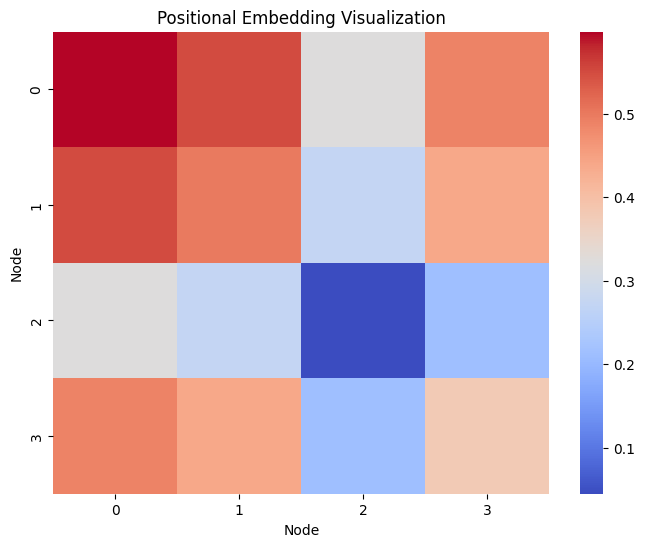

In [ ]:
visualize_embeddings(pos_emb_combined, title="Positional Embedding Visualization")

In [ ]:
pos_emb

hidden_states = nn.functional.gelu(hidden_states, approximate="tanh")

x = x * torch.sigmoid(1.702 * x)  # QuickGELU activation functi

tensor([[[ 0.8415,  0.5403,  0.0100,  0.9999],
         [ 0.0000,  1.0000,  0.0000,  1.0000],
         [ 0.1411, -0.9900,  0.0300,  0.9996],
         [ 0.9093, -0.4161,  0.0200,  0.9998]],

        [[ 0.8415,  0.5403,  0.0100,  0.9999],
         [ 0.0000,  1.0000,  0.0000,  1.0000],
         [ 0.1411, -0.9900,  0.0300,  0.9996],
         [ 0.9093, -0.4161,  0.0200,  0.9998]]], grad_fn=<UnsafeViewBackward0>)

In [ ]:
pos_emb_combined[0]

tensor([[[ 0.8415,  0.5403,  0.0100,  0.9999,  0.8415,  0.5403,  0.0100,
           0.9999],
         [ 0.8415,  0.5403,  0.0100,  0.9999,  0.0000,  1.0000,  0.0000,
           1.0000],
         [ 0.8415,  0.5403,  0.0100,  0.9999,  0.1411, -0.9900,  0.0300,
           0.9996],
         [ 0.8415,  0.5403,  0.0100,  0.9999,  0.9093, -0.4161,  0.0200,
           0.9998]],

        [[ 0.0000,  1.0000,  0.0000,  1.0000,  0.8415,  0.5403,  0.0100,
           0.9999],
         [ 0.0000,  1.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000,
           1.0000],
         [ 0.0000,  1.0000,  0.0000,  1.0000,  0.1411, -0.9900,  0.0300,
           0.9996],
         [ 0.0000,  1.0000,  0.0000,  1.0000,  0.9093, -0.4161,  0.0200,
           0.9998]],

        [[ 0.1411, -0.9900,  0.0300,  0.9996,  0.8415,  0.5403,  0.0100,
           0.9999],
         [ 0.1411, -0.9900,  0.0300,  0.9996,  0.0000,  1.0000,  0.0000,
           1.0000],
         [ 0.1411, -0.9900,  0.0300,  0.9996,  0.1411, -0.9900,  0

In [ ]:
pos_emb_combined.shape

torch.Size([2, 4, 4, 8])

In [ ]:
x.shape

torch.Size([2, 4, 4, 4])

In [ ]:
scores_sorted = scores.sort(descending=True, dim=1)[0]
pairwise_diff = (scores.transpose(1, 2) - scores_sorted).abs().neg() / 1.0
perm = pairwise_diff.softmax(-1)
if not True:
    perm_ = torch.zeros_like(perm, device=perm.device)
    perm_.scatter_(-1, perm.topk(1, -1)[1], value=1)
    perm = (perm_ - perm).detach() + perm

In [ ]:
batch_size, num_nodes = mask.size(0), mask.size(1)
eye = (
    torch.eye(num_nodes, num_nodes)
    .unsqueeze(0)
    .expand(batch_size, -1, -1)
    .type_as(perm)
)
mask = mask.unsqueeze(-1).expand(-1, -1, num_nodes)
perm = torch.where(mask, perm, eye)

In [ ]:
def permutation_matrix_90(n=6):
    P = np.zeros((n * n, n * n), dtype=int)
    for i in range(n):
        for j in range(n):
            original_index = i * n + j
            rotated_index = j * n + (n - 1 - i)
            P[rotated_index, original_index] = 1
    return torch.tensor(P, dtype=torch.float32)


def x_axis_reflection_matrix(n=6):
    P = np.zeros((n * n, n * n), dtype=int)
    for i in range(n):
        for j in range(n):
            original_index = i * n + j
            reflected_index = (n - 1 - i) * n + j
            P[reflected_index, original_index] = 1
    return torch.tensor(P, dtype=torch.float32)


def y_axis_reflection_matrix(n=6):
    P = np.zeros((n * n, n * n), dtype=int)
    for i in range(n):
        for j in range(n):
            original_index = i * n + j
            reflected_index = i * n + (n - 1 - j)
            P[reflected_index, original_index] = 1
    return torch.tensor(P, dtype=torch.float32)


P_90 = permutation_matrix_90(2)
P_x_reflection = x_axis_reflection_matrix(2)

In [ ]:
def permutation_matrix_90(n=6):
    indices = torch.arange(n * n).reshape(n, n)
    rotated_indices = indices.rot90(-1).reshape(-1)
    perm = torch.eye(n * n, dtype=torch.float32)[rotated_indices]
    return perm


def y_axis_reflection_matrix(n=6):
    indices = torch.arange(n * n).reshape(n, n)
    reflected_indices = indices.flip(1).reshape(-1)
    perm = torch.eye(n * n, dtype=torch.float32)[reflected_indices]
    return perm

In [ ]:
perm = torch.eye(4, dtype=torch.float32)
perm_90 = permutation_matrix_90(2)
perm_180 = torch.matmul(perm_90, perm_90)
perm_270 = torch.matmul(perm_180, perm_90)

perm_y_reflection = y_axis_reflection_matrix(2)
perm_y_reflection_90 = torch.matmul(perm_y_reflection, perm_90)
perm_y_reflection_180 = torch.matmul(perm_y_reflection, perm_180)
perm_y_reflection_270 = torch.matmul(perm_y_reflection, perm_270)

In [ ]:
def create_predefine_permutations(n: int):
    perm = torch.eye(4, dtype=torch.float32)
    perm_90 = permutation_matrix_90(n)
    perm_180 = torch.matmul(perm_90, perm_90)
    perm_270 = torch.matmul(perm_180, perm_90)

    perm_y_reflection = y_axis_reflection_matrix(n)
    perm_y_reflection_90 = torch.matmul(perm_y_reflection, perm_90)
    perm_y_reflection_180 = torch.matmul(perm_y_reflection, perm_180)
    perm_y_reflection_270 = torch.matmul(perm_y_reflection, perm_270)

    permutations = torch.stack(
        [
            perm,
            perm_90,
            perm_180,
            perm_270,
            perm_y_reflection,
            perm_y_reflection_90,
            perm_y_reflection_180,
            perm_y_reflection_270,
        ]
    )
    return permutations

In [ ]:
class SimplePermuter(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.scoring_fc = torch.nn.Linear(2, 8)
        predefined_permutations = self.create_predefine_permutations(2)
        # Predefined permutation matrices (B, num_permutations, N, N)
        self.register_buffer("predefined_permutations", predefined_permutations)

    def forward(self, node_features, mask, hard=False, tau=1.0):
        # Add noise to break symmetry
        node_features = node_features + torch.randn_like(node_features) * 0.05

        # Score each permutation option
        scores = self.scoring_fc(node_features).mean(dim=1)  # (B, num_permutations)

        # Softmax over scores to get probabilities for each permutation
        probs = torch.softmax(scores / tau, dim=-1)  # (B, num_permutations)

        # Hard selection using Gumbel-Softmax (discrete but differentiable)
        one_hot = torch.zeros_like(probs)
        one_hot.scatter_(1, probs.argmax(dim=-1, keepdim=True), 1.0)
        probs = (one_hot - probs).detach() + probs

        # Combine predefined permutations with the probabilities
        # Shape: (B, N, N) = (B, num_permutations, N, N) * (B, num_permutations, 1, 1)
        # Expand probs to (B, num_permutations, 1, 1) to match (num_permutations, N, N)
        probs = probs.unsqueeze(-1).unsqueeze(-1)  # (B, num_permutations, 1, 1)
        # Combine predefined permutations with probabilities
        # Shape: (B, N, N) = (B, num_permutations, 1, 1) * (num_permutations, N, N) -> sum over 8
        perm = torch.sum(probs * self.predefined_permutations, dim=1)  # (B, N, N)

        return perm

    def _permutation_matrix_90(self, n: int) -> torch.Tensor:
        indices = torch.arange(n * n).reshape(n, n)
        rotated_indices = indices.rot90(-1).reshape(-1)
        perm = torch.eye(n * n, dtype=torch.float32)[rotated_indices]
        return perm

    def _y_axis_reflection_matrix(self, n: int) -> torch.Tensor:
        indices = torch.arange(n * n).reshape(n, n)
        reflected_indices = indices.flip(1).reshape(-1)
        perm = torch.eye(n * n, dtype=torch.float32)[reflected_indices]
        return perm

    def create_predefine_permutations(self, n: int) -> torch.Tensor:
        perm = torch.eye(n**n, dtype=torch.float32)
        perm_90 = self._permutation_matrix_90(n)
        perm_180 = torch.matmul(perm_90, perm_90)
        perm_270 = torch.matmul(perm_180, perm_90)

        perm_y_reflection = self._y_axis_reflection_matrix(n)
        perm_y_reflection_90 = torch.matmul(perm_y_reflection, perm_90)
        perm_y_reflection_180 = torch.matmul(perm_y_reflection, perm_180)
        perm_y_reflection_270 = torch.matmul(perm_y_reflection, perm_270)

        permutations = torch.stack(
            [
                perm,
                perm_90,
                perm_180,
                perm_270,
                perm_y_reflection,
                perm_y_reflection_90,
                perm_y_reflection_180,
                perm_y_reflection_270,
            ]
        )
        return permutations

    @staticmethod
    def permute_node_features(node_features, perm):
        """Apply the permutation to node features."""
        return torch.matmul(perm, node_features)

In [ ]:
permuter = SimplePermuter()

In [ ]:
perm = permuter(node_features, mask, hard=True)

In [ ]:
perm = torch.stack([perm_90, perm_180])

In [ ]:
SimplePermuter.permute_node_features(node_features, perm)

tensor([[[ 5.,  6.],
         [ 1.,  2.],
         [ 7.,  8.],
         [ 3.,  4.]],

        [[13., 14.],
         [11., 12.],
         [ 9., 10.],
         [ 7.,  8.]]])

In [ ]:
# 1 2  2 1
# 3 4  4 3

# 3 1  1 3
# 4 2  2 4

# 4 3  3 4
# 2 1  1 2

# 2 4  4 2
# 1 3  3 1

In [ ]:
node_features

tensor([[[ 1.,  2.],
         [ 3.,  4.],
         [ 5.,  6.],
         [ 7.,  8.]],

        [[ 7.,  8.],
         [ 9., 10.],
         [11., 12.],
         [13., 14.]]])

In [ ]:
torch.matmul(perm_y_reflection_90, node_features)

tensor([[[ 1.,  2.],
         [ 5.,  6.],
         [ 3.,  4.],
         [ 7.,  8.]],

        [[ 7.,  8.],
         [11., 12.],
         [ 9., 10.],
         [13., 14.]]])

In [ ]:
node_features

tensor([[[ 1.,  2.],
         [ 3.,  4.],
         [ 5.,  6.],
         [ 7.,  8.]],

        [[ 7.,  8.],
         [ 9., 10.],
         [11., 12.],
         [13., 14.]]])

In [ ]:
input_projection = nn.Linear(4, 3 * 4, bias=False)
output_projection = nn.Linear(4, 4, bias=False)

In [ ]:
batch_size, num_nodes = x.size(0), x.size(1)
projected = input_projection(x)

device = x.device

q_chunk, k_chunk, v_chunk = torch.chunk(projected, chunks=3, dim=-1)
query = q_chunk.view(batch_size, num_nodes, num_nodes, 2, -1).permute(0, 3, 1, 2, 4)
key = k_chunk.view(batch_size, num_nodes, num_nodes, 2, -1).permute(0, 3, 2, 1, 4)
value = v_chunk.view(batch_size, num_nodes, num_nodes, 2, -1).permute(0, 3, 2, 1, 4)

attn_mask = edge_mask
# .masked_fill(
#     torch.eye(num_nodes, num_nodes, device=device).bool(), 0
# )
attn_mask = attn_mask.unsqueeze(1).expand(-1, num_nodes, -1, -1)
# attn_mask = attn_mask * (
#     torch.eye(num_nodes, num_nodes, device=device) == 0
# ).bool().unsqueeze(0).unsqueeze(-2).expand(-1, -1, num_nodes, -1)

attention_output = scaled_dot_product_attention(
    query=query,
    key=key,
    value=value,
    attn_mask=attn_mask,
    is_causal=False,
)
attention_output = attention_output.permute(0, 2, 3, 1, 4).contiguous()
output = output_projection(attention_output.transpose(1, 2).flatten(-2))

In [ ]:
node_features = torch.diagonal(output, dim1=1, dim2=2).transpose(1, 2)
graph_emb, node_features = node_features[:, 0], node_features[:, 1:]

In [ ]:
node_features.shape

torch.Size([2, 4, 4])

In [ ]:
graph_emb.shape

torch.Size([2, 4])

In [ ]:
node_features.shape

torch.Size([2, 4, 4])

In [ ]:
node_features_combined.shape

torch.Size([2, 5, 5, 4])

In [ ]:
attn_weight.shape

torch.Size([2, 2, 5, 5, 5])

In [ ]:
query.shape

torch.Size([2, 2, 5, 5, 2])

In [ ]:
attn_bias[0][0]

tensor([[[-inf, 0., 0., 0., 0.],
         [-inf, -inf, 0., 0., 0.],
         [-inf, 0., -inf, 0., 0.],
         [-inf, 0., 0., -inf, 0.],
         [-inf, 0., 0., 0., -inf]],

        [[-inf, -inf, 0., 0., 0.],
         [0., -inf, 0., 0., 0.],
         [0., -inf, -inf, 0., 0.],
         [0., -inf, 0., -inf, 0.],
         [0., -inf, 0., 0., -inf]],

        [[-inf, 0., -inf, 0., 0.],
         [0., -inf, -inf, 0., 0.],
         [0., 0., -inf, 0., 0.],
         [0., 0., -inf, -inf, 0.],
         [0., 0., -inf, 0., -inf]],

        [[-inf, 0., 0., -inf, 0.],
         [0., -inf, 0., -inf, 0.],
         [0., 0., -inf, -inf, 0.],
         [0., 0., 0., -inf, 0.],
         [0., 0., 0., -inf, -inf]],

        [[-inf, 0., 0., 0., -inf],
         [0., -inf, 0., 0., -inf],
         [0., 0., -inf, 0., -inf],
         [0., 0., 0., -inf, -inf],
         [0., 0., 0., 0., -inf]]])

In [ ]:
projected.shape

torch.Size([2, 5, 5, 12])

In [ ]:
import os
import rootutils

rootutils.setup_root(os.getcwd(), indicator=".project-root", pythonpath=True)

PosixPath('/Users/tomeknocon/MIM/Master_Thesis/IMMUVIS-PIGVAE')

In [ ]:
from torchvision import transforms
import torch
from src.data.components.graphs_datamodules import (
    SplitPatches,
)
from src.data.mnist_datamodule import MNISTDataModule

In [ ]:
from torchvision.datasets import MNIST
from torch.utils.data import ConcatDataset, Dataset, random_split

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
        transforms.Resize((24, 24)),
        transforms.Lambda(lambda x: x.unsqueeze(0)),
        SplitPatches(4),
    ]
)

trainset = MNIST("../data", train=True, transform=transform)
testset = MNIST("../data", train=False, transform=transform)
dataset = ConcatDataset(datasets=[trainset, testset])

In [ ]:
data_train, data_val, data_test = random_split(
    dataset=dataset,
    lengths=[100, 10, 69890],
    generator=torch.Generator().manual_seed(42),
)

In [ ]:
import networkx as nx


class GridGraphDataset(Dataset):
    def __init__(
        self,
        dataset,
        grid_size: int,
        channels,
    ):
        self.grid_size = grid_size
        self.dataset = dataset
        self.channels = channels

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        g = nx.grid_graph((self.grid_size, self.grid_size))
        img = self.dataset[idx][0].to(torch.float32)
        target = self.dataset[idx][1]
        return (g, img, target)

In [ ]:
d = GridGraphDataset(data_train, 6, [0])

In [ ]:
m = MNISTDataModule("../data", [100, 10, 69890], 32, 1)

In [ ]:
m.setup()
t = m.train_dataloader()

In [ ]:
batches = [el for el in t]

In [ ]:
batches[0]

DenseGraphBatch(edge_features=[0], mask=[32, 36], node_features=[32, 36, 16], properties=[32], y=[32])

In [ ]:
from dataclasses import dataclass
import os

DEFAULT_SAVE_DIR = os.path.join(os.getcwd())


@dataclass
class Params:
    id: int = 0
    num_epochs: int = 10
    num_eval_samples: int = 8192
    eval_freq: int = 1000
    save_dir: str = DEFAULT_SAVE_DIR
    precision: int = 32
    progress_bar: bool = True
    test: bool = False
    resume_ckpt: str = ""
    batch_size: int = 32
    lr: float = 0.0005
    kld_loss_scale: float = 0.001
    perm_loss_scale: float = 0.5
    property_loss_scale: float = 0.1
    vae: bool = True
    num_node_features: int = 16
    num_edge_features: int = 0
    emb_dim: int = 16
    grid_size: int = 6
    graph_encoder_hidden_dim: int = 32
    graph_encoder_k_dim: int = 8
    graph_encoder_v_dim: int = 8
    graph_encoder_num_heads: int = 2
    graph_encoder_ppf_hidden_dim: int = 128
    graph_encoder_num_layers: int = 4
    graph_decoder_hidden_dim: int = 32
    graph_decoder_k_dim: int = 8
    graph_decoder_v_dim: int = 8
    graph_decoder_num_heads: int = 2
    graph_decoder_ppf_hidden_dim: int = 128
    graph_decoder_pos_emb_dim: int = 8
    graph_decoder_num_layers: int = 4
    property_predictor_hidden_dim: int = 32
    num_properties: int = 1
    num_workers: int = 1
    shuffle: int = 1
    graph_family: str = "grid"
    n_min: int = 12
    n_max: int = 20
    p_min: float = 0.4
    p_max: float = 0.6
    m_min: int = 1
    m_max: int = 5


# Example usage
hparams = Params()

# Convert to dictionary
# params_dict = asdict(hparams)

# print(params_dict)

ModuleNotFoundError: No module named 'models'

In [ ]:
import sys
import os
import torch

# Add root directory to sys.path
sys.path.append(os.path.abspath("../src"))

In [ ]:
import sys
import os
import torch

# Add root directory to sys.path
sys.path.append(os.path.abspath("../"))

In [ ]:
import hydra
from omegaconf import OmegaConf

In [ ]:
cfg = OmegaConf.load("../configs/model/model.yaml")
model = hydra.utils.instantiate(cfg)

/Users/tomeknocon/MIM/Master_Thesis/IMMUVIS-PIGVAE/src/models/components/spectral_embeddings.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:278.)
  sorted_eigenvecs = torch.tensor(
/Users/tomeknocon/opt/anaconda3/envs/pigvae/lib/python3.8/site-packages/torch/nn/init.py:452: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")
/Users/tomeknocon/opt/anaconda3/envs/pigvae/lib/python3.8/site-packages/lightning/pytorch/utilities/parsing.py:208: Attribute 'critic' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['critic'])`.
/Users/tomeknocon/opt/anaconda3/envs/pigvae/lib/python3.

In [ ]:
model.load_state_dict(
    torch.load("../logs/train/runs/2025-02-21_00-38-31/checkpoints/last.ckpt")[
        "state_dict"
    ]
)
model.eval()

PLGraphAE(
  (graph_ae): GraphAE(
    (encoder): GraphEncoder(
      (posiotional_embedding): PositionalEncoding()
      (graph_transformer): Transformer(
        (blocks): ModuleList(
          (0-3): 4 x TransformerBlock(
            (attention_layer): SelfAttention(
              (layer_norm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
              (input_projection): Linear(in_features=32, out_features=96, bias=False)
              (output_projection): Linear(in_features=32, out_features=32, bias=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (feed_forward_layer): Sequential(
              (ff_layernorm): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
              (pre_relu): Linear(in_features=32, out_features=128, bias=True)
              (relu): ReLU()
              (post_relu): Linear(in_features=128, out_features=32, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
          )
        )
 

In [ ]:
a = [4, 5, 6]

In [ ]:
a

[4, 5, 6]

In [ ]:
a.clear()

In [ ]:
a

[]

In [ ]:
batches[0].node_features.shape

torch.Size([32, 36, 16])

In [ ]:
b = model(batches[-2], False)

In [ ]:
from src.models.components.losses import GraphReconstructionLoss

In [ ]:
gpl = GraphReconstructionLoss()


gpl(batches[-2], b[0])

{'node_loss': tensor(0.4534, grad_fn=<MseLossBackward0>),
 'loss': tensor(0.4534, grad_fn=<MseLossBackward0>)}

In [ ]:
batches[-2].node_features

tensor([[[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         ...,
         [ 2.3243,  2.7960,  2.4508,  ...,  0.1266, -0.1642, -0.4086],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]],

        [[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         ...,
         [ 1.4401,  1.4438,  1.4389,  ..., -0.4242, -0.4242, -0.4242],
         [ 0.7069,  0.0601, -0.3897,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242]],

        [[-0.4242, -0.4242, -0.4242,  ..., -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242,  ..., -0

In [ ]:
(b[0].node_features - batches[-2].node_features).sum()

tensor(-0.6641, grad_fn=<DivBackward0>)

In [ ]:
import torch
import torch.nn as nn

In [ ]:
a = torch.randn(32, 36, 16)

linear = nn.Linear(16, 128)

a = linear(a)

In [ ]:
import networkx as nx


class NetworkXSpectralEmbedding(nn.Module):
    def __init__(self, d_model: int, grid_size: int, dropout: float = 0.1):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        self.G = nx.grid_2d_graph(grid_size, grid_size)
        sorted_eigenvecs = torch.tensor(
            np.stack(list(nx.spectral_layout(self.G, dim=d_model).values())),
            dtype=torch.float32,
        )

        self.register_buffer("sorted_eigenvecs", sorted_eigenvecs)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch, _, _ = x.shape
        embbeding = torch.tile(self.sorted_eigenvecs, (batch, 1, 1))
        print(embbeding.shape)
        x = x + embbeding
        return self.dropout(x)

In [ ]:
a = NetworkXSpectralEmbedding(128, 6)

ValueError: operands could not be broadcast together with shapes (36,35) (128,) 

In [ ]:
b = torch.randn(32, 36, 128)

In [ ]:
a(b).shape

torch.Size([32, 36, 14])


torch.Size([32, 36, 14])

In [ ]:
def mse(image1, image2):
    """
    Compute the Mean Squared Error between two single-channel images.

    Args:
        image1 (numpy.ndarray): First grayscale image.
        image2 (numpy.ndarray): Second grayscale image.

    Returns:
        float: The Mean Squared Error.
    """
    # Check if both images have the same shape
    if image1.shape != image2.shape:
        raise ValueError("Images must have the same dimensions")

    # Compute the squared differences
    squared_diff = (image1 - image2) ** 2

    # Calculate MSE
    mse_value = torch.mean(squared_diff)
    return mse_value

In [ ]:
b[0].node_features

tensor([[[-0.5440, -0.4148, -0.3804,  ..., -0.4201, -0.5129, -0.3170],
         [-0.6075, -0.3967, -0.4742,  ..., -0.4418, -0.5977, -0.4123],
         [-0.4829, -0.4074, -0.4939,  ..., -0.3531, -0.4312, -0.4726],
         ...,
         [ 0.9148,  1.6158,  1.7351,  ...,  1.7829,  1.3208,  0.8090],
         [-0.3979, -0.4019, -0.2883,  ..., -0.2926, -0.3526, -0.3601],
         [-0.4589, -0.4015, -0.5237,  ..., -0.3733, -0.4550, -0.4852]],

        [[-0.3329, -0.4453, -0.4062,  ..., -0.3111, -0.3978, -0.3099],
         [-0.4433, -0.3668, -0.3822,  ..., -0.3199, -0.3469, -0.3696],
         [-0.5160, -0.3700, -0.5476,  ..., -0.3381, -0.4032, -0.4413],
         ...,
         [-0.0911, -0.2197, -0.2586,  ..., -0.2111, -0.1831, -0.0415],
         [-0.5568, -0.4114, -0.4290,  ..., -0.3857, -0.5087, -0.3441],
         [-0.3626, -0.3900, -0.5278,  ..., -0.3808, -0.3907, -0.4012]],

        [[-0.3827, -0.4412, -0.3692,  ..., -0.3226, -0.3961, -0.3606],
         [-0.4701, -0.3637, -0.3498,  ..., -0

In [ ]:
def restore_tensor(a, bs, c, h, w, patch_size):
    # Step 1: Reshape a to match the patch grid layout
    a = a.view(bs, -1, c, patch_size, patch_size)
    # a -> (B, num_patches, C, patch_size, patch_size)

    # Step 2: Reshape back to (B, C, H, W) by folding the patches
    # Calculate the grid size (L) which is the number of patches in each row and column
    grid_size = int(
        a.size(1) ** 0.5
    )  # Assumes square grid (height = width for the patches)

    # Unfold back into the original image size
    a = a.view(bs, grid_size, grid_size, c, patch_size, patch_size)
    # a -> (B, grid_size, grid_size, C, patch_size, patch_size)

    # Step 3: Permute and reshape to get back to the image format (B, C, H, W)
    x_reconstructed = a.permute(0, 3, 1, 4, 2, 5).contiguous()
    # x_reconstructed -> (B, C, grid_size, patch_size, grid_size, patch_size)

    x_reconstructed = x_reconstructed.view(bs, c, h, w)
    # x_reconstructed -> (B, C, H, W)

    return x_reconstructed

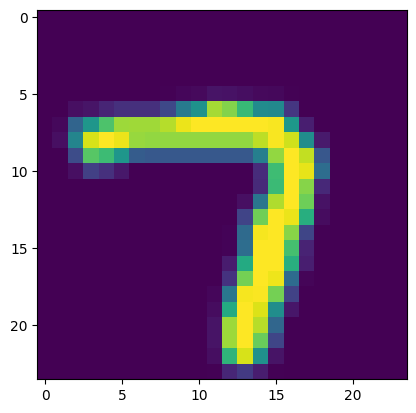

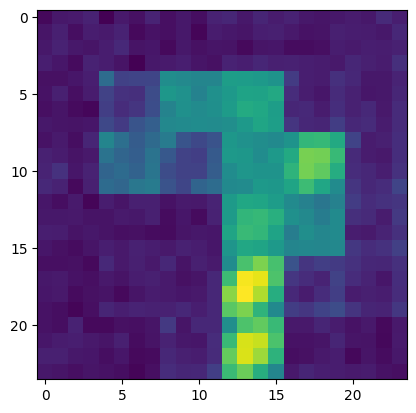

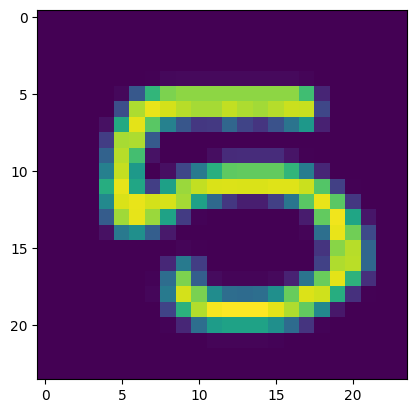

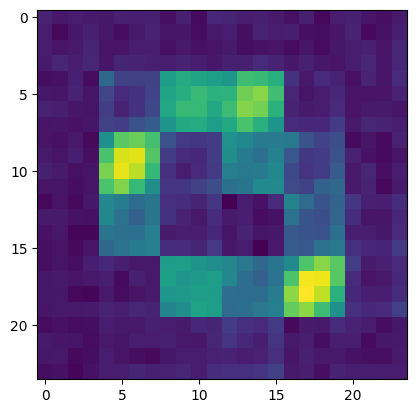

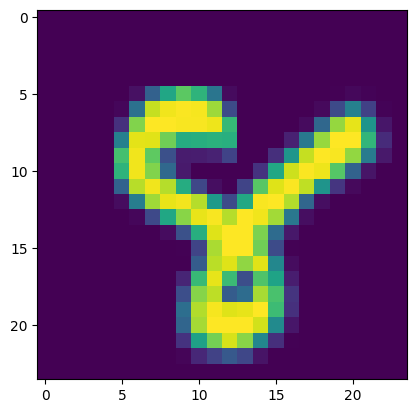

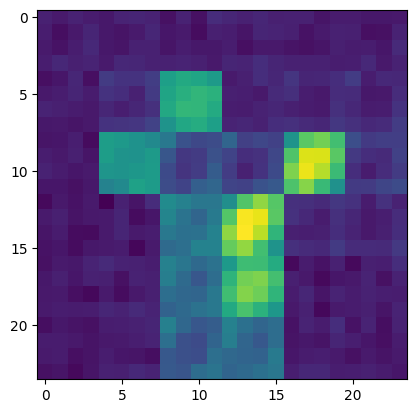

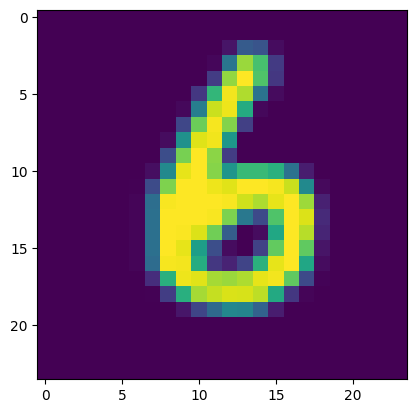

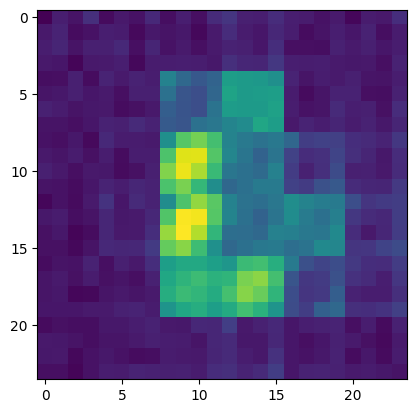

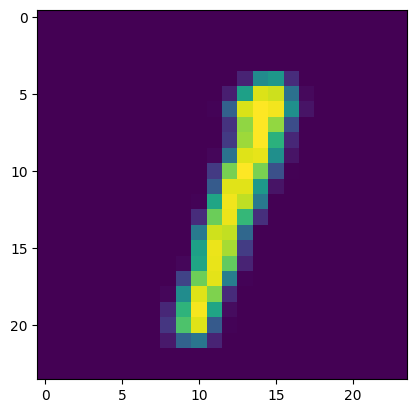

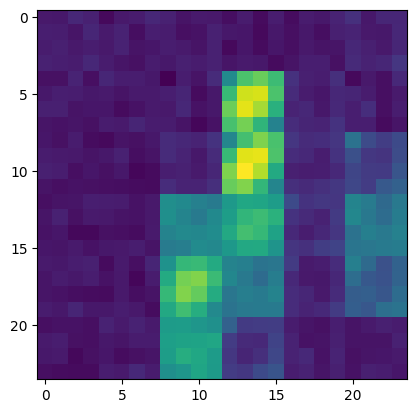

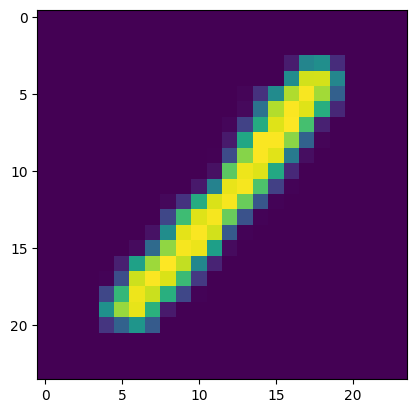

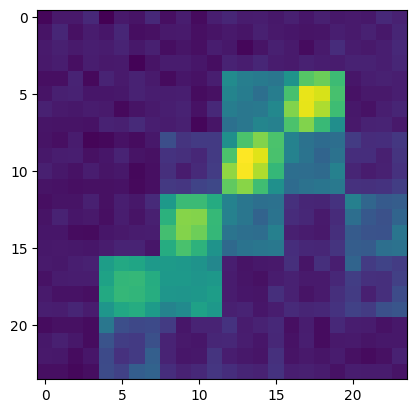

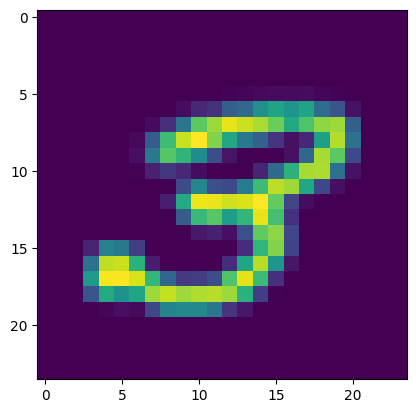

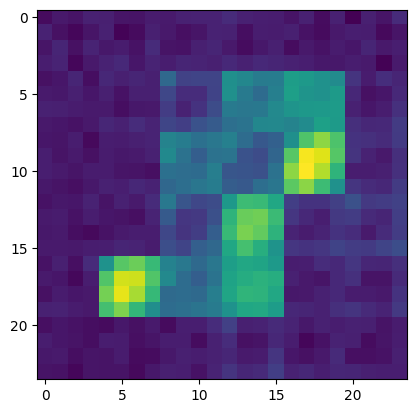

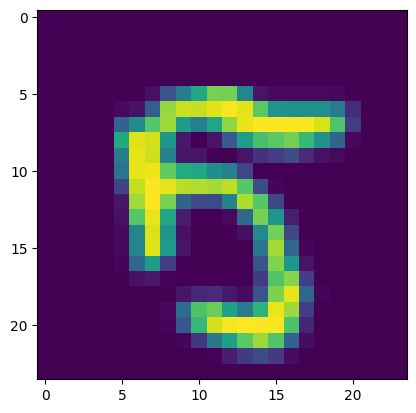

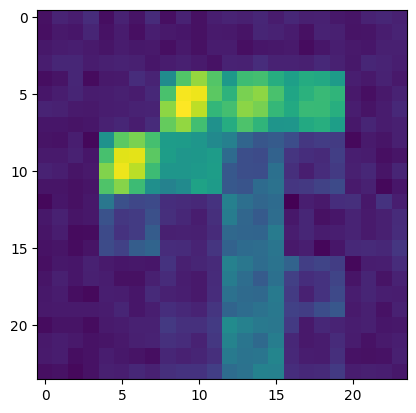

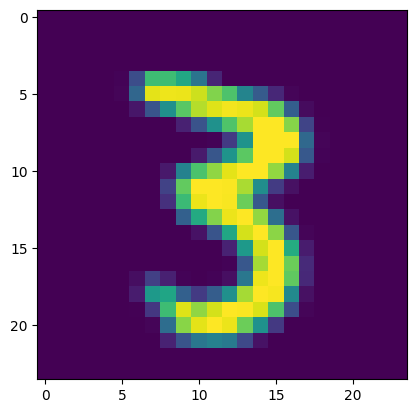

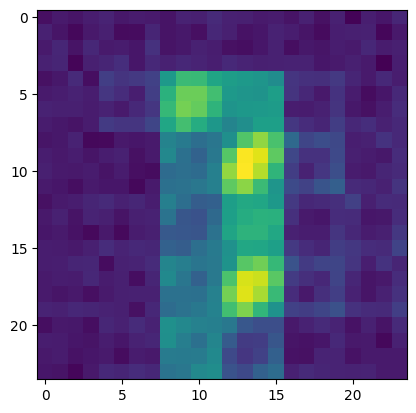

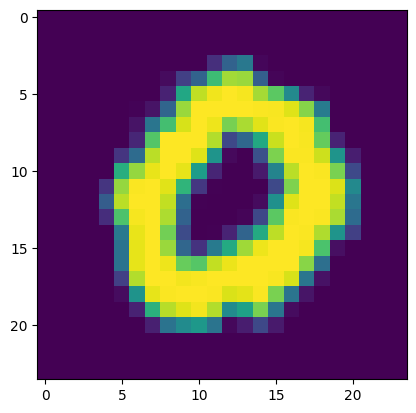

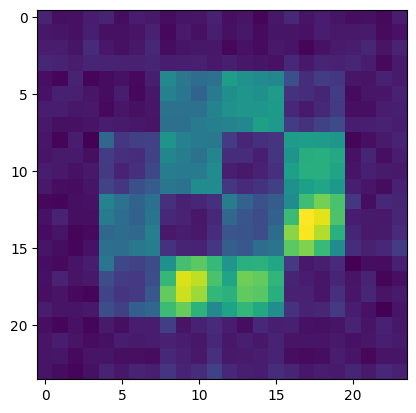

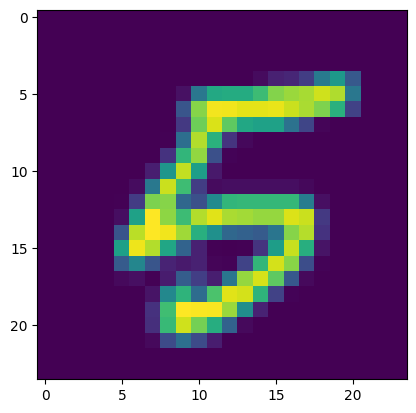

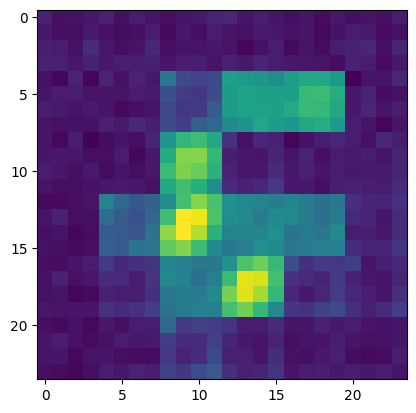

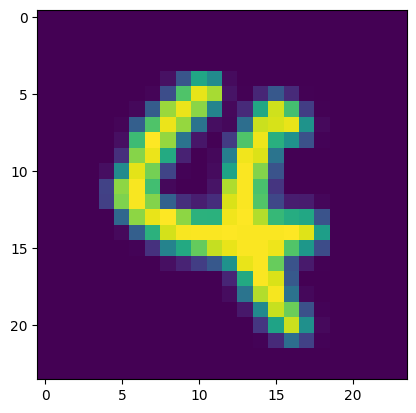

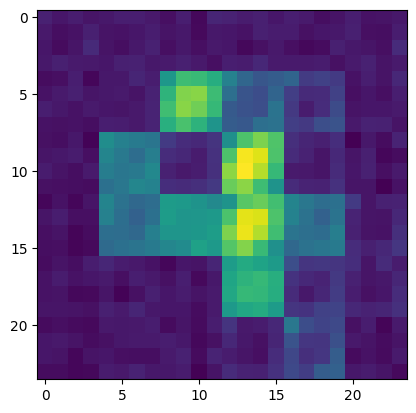

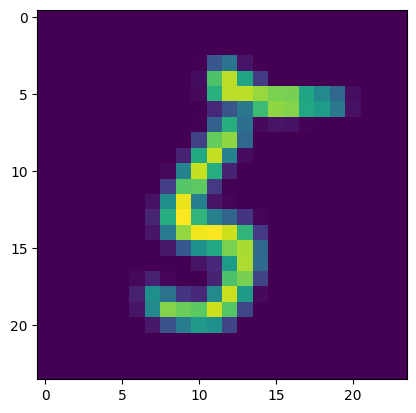

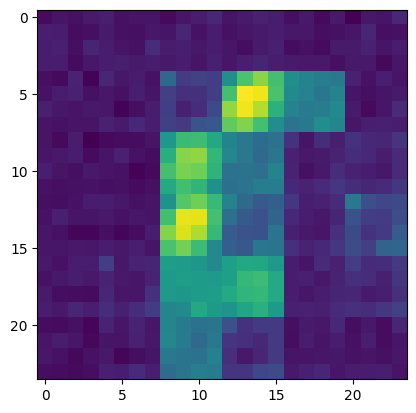

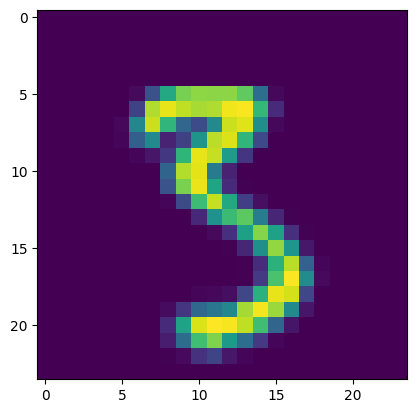

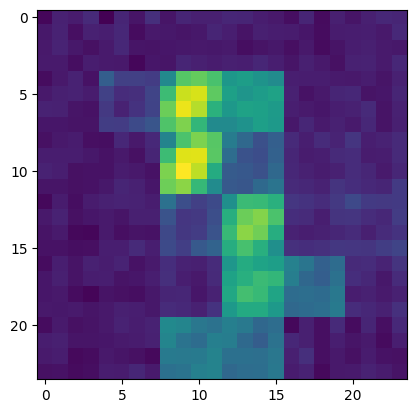

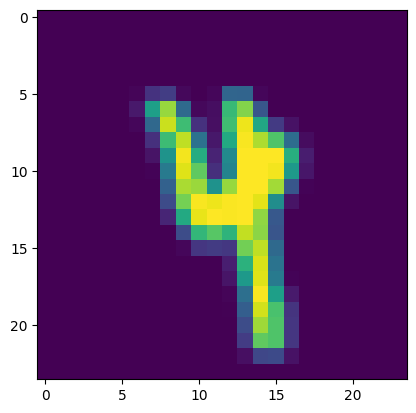

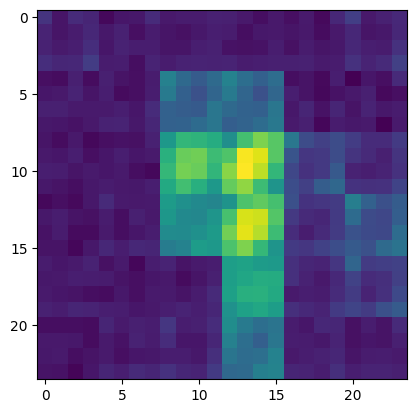

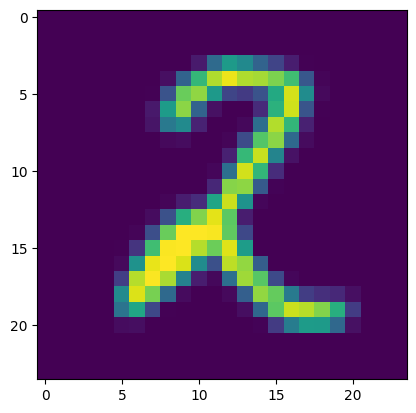

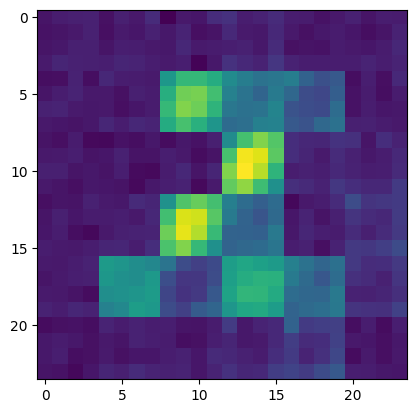

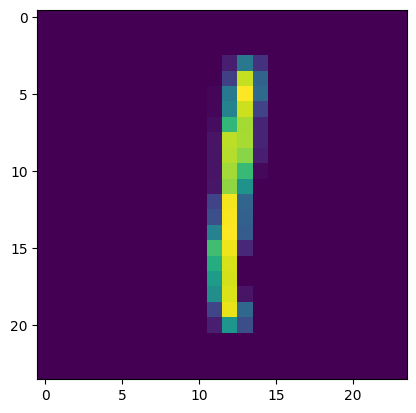

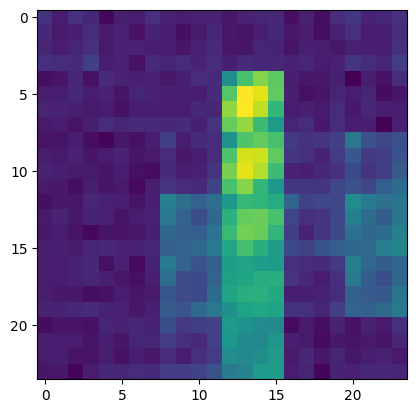

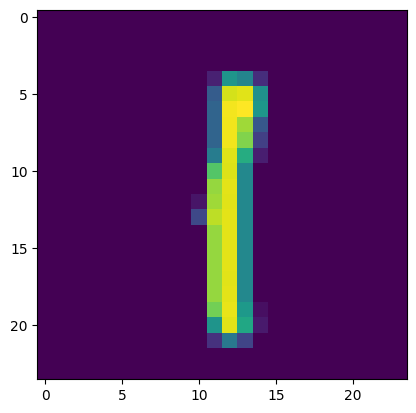

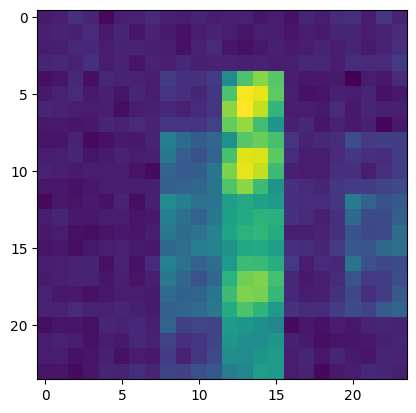

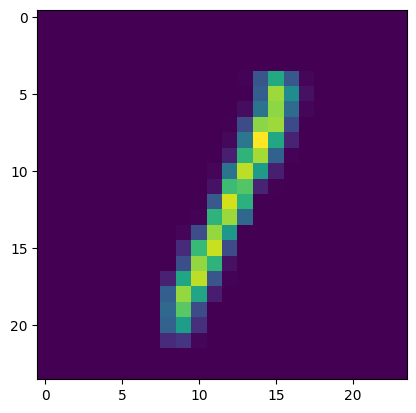

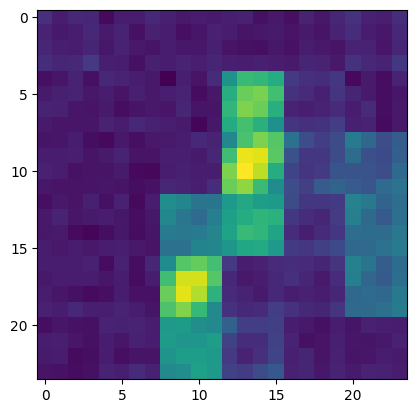

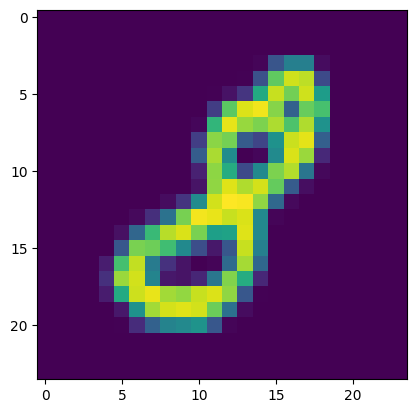

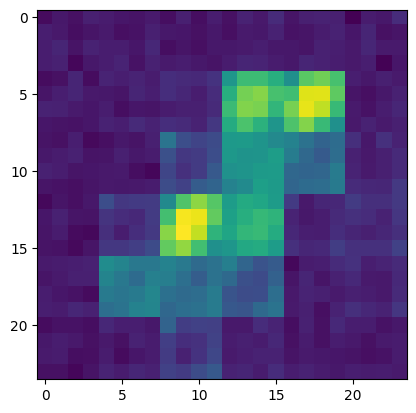

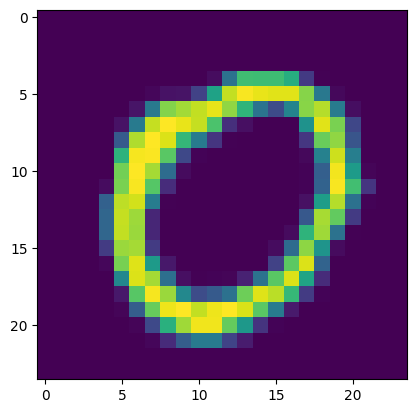

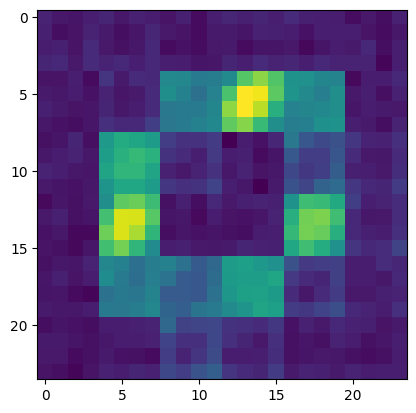

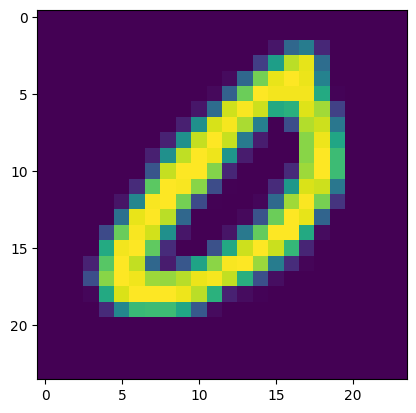

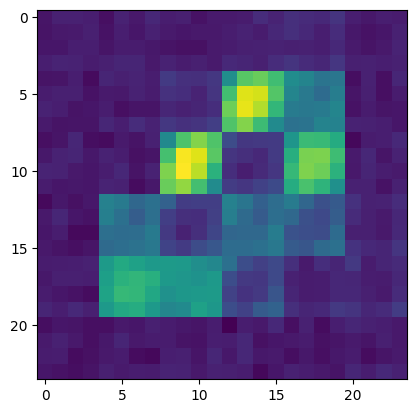

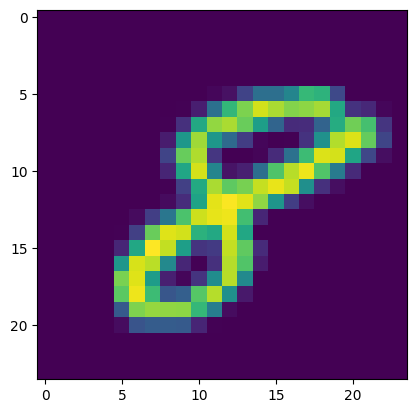

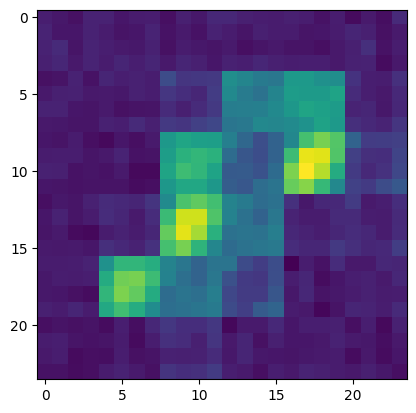

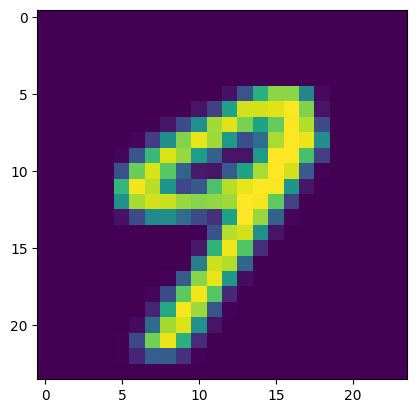

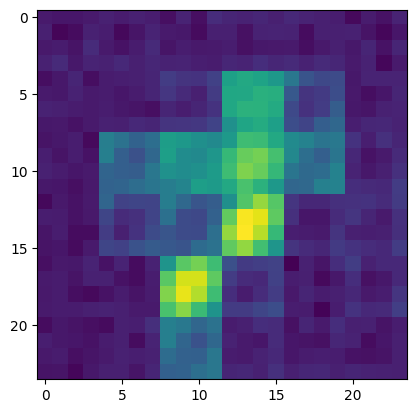

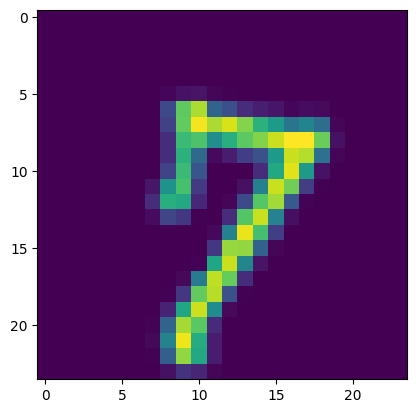

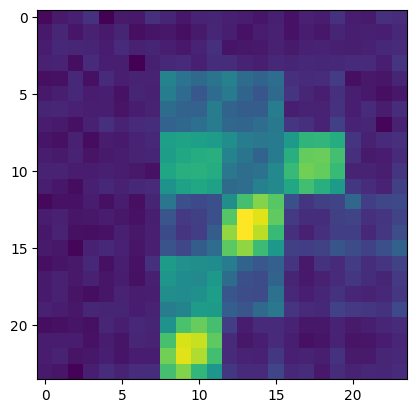

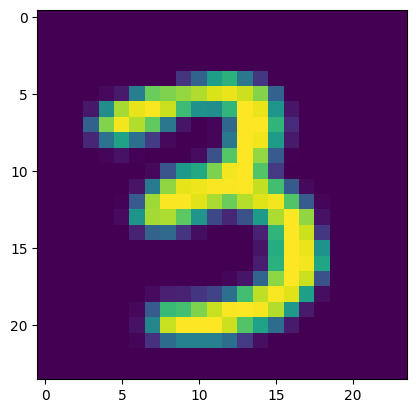

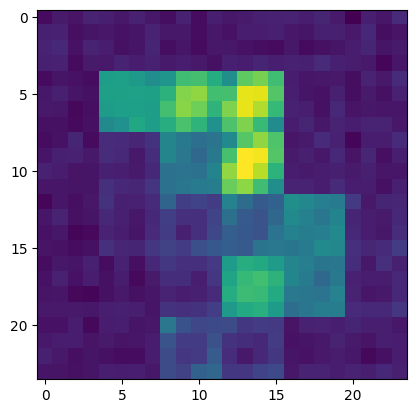

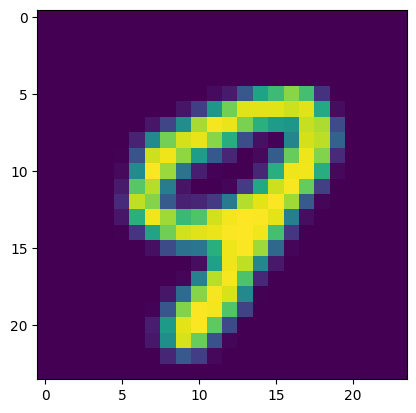

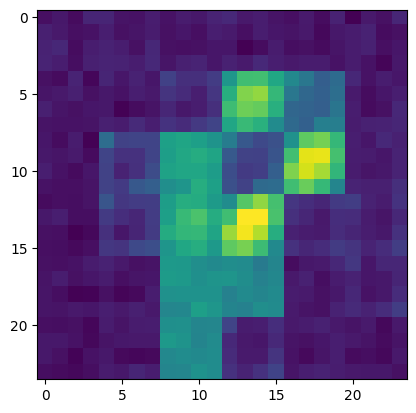

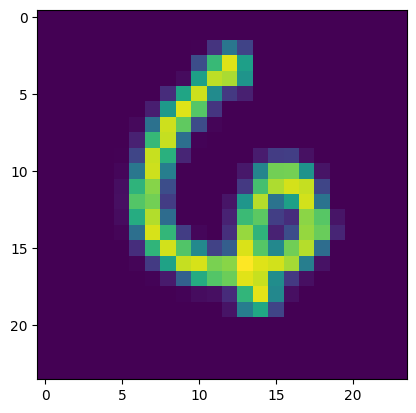

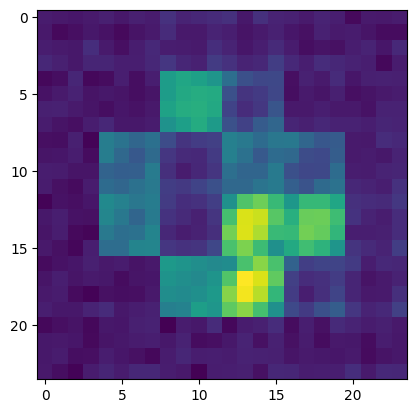

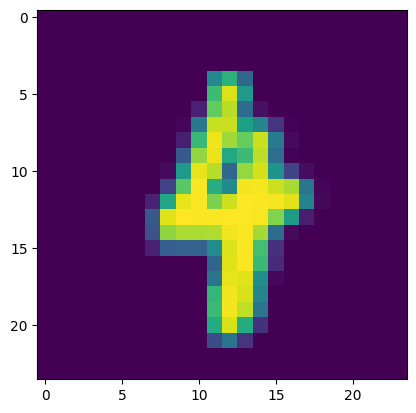

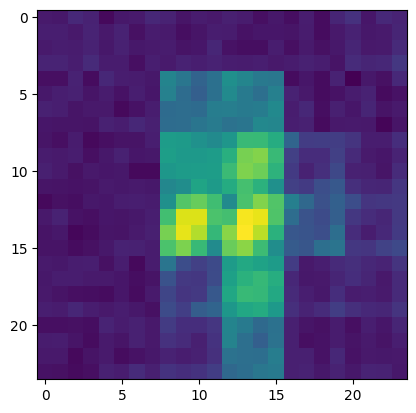

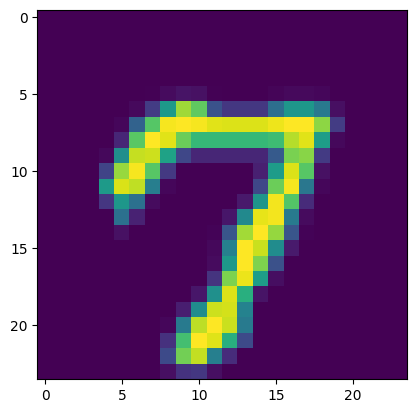

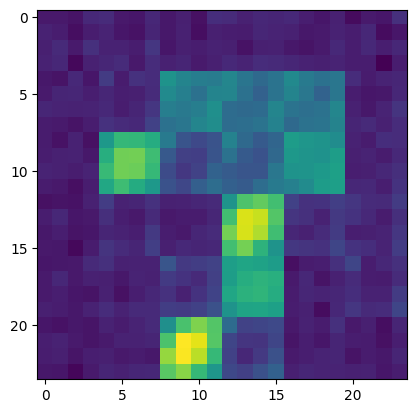

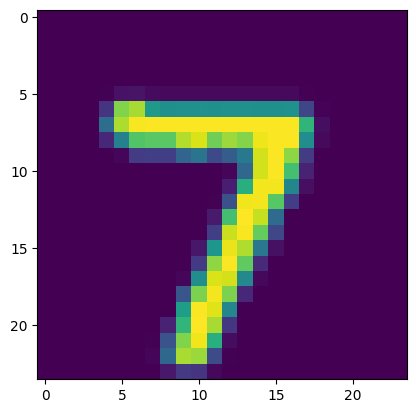

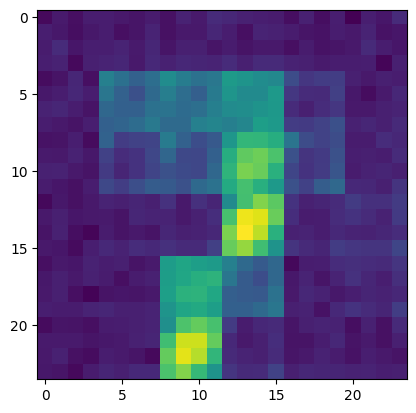

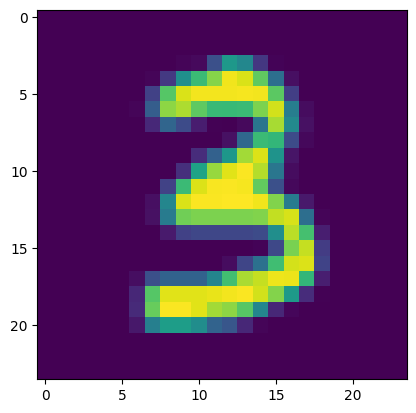

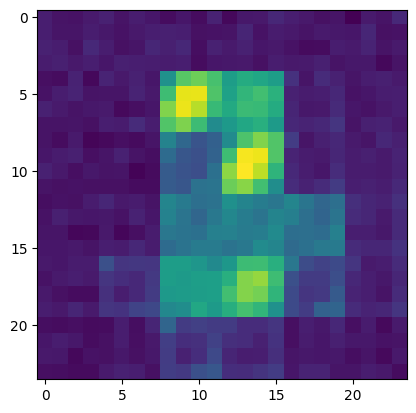

In [ ]:
import matplotlib.pyplot as plt

for i in range(32):
    org = restore_tensor(batches[-2].node_features, 32, 1, 24, 24, 4)
    pred = restore_tensor(b[0].node_features, 32, 1, 24, 24, 4)

    plt.imshow(org[i].reshape(24, 24, 1).detach().numpy())
    plt.show()

    plt.imshow(pred[i].reshape(24, 24, 1).detach().numpy())
    plt.show()

In [ ]:
def scaled_dot_product_attention(
    query,
    key,
    value,
    attn_mask=None,
    dropout_p=0.0,
    is_causal=False,
    scale=None,
    enable_gqa=False,
) -> torch.Tensor:
    L, S = query.size(-2), key.size(-2)
    scale_factor = 1 / math.sqrt(query.size(-1)) if scale is None else scale
    attn_bias = torch.zeros(L, S, dtype=query.dtype, device=query.device)
    if is_causal:
        assert attn_mask is None
        temp_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0)
        attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
        attn_bias.to(query.dtype)

    if attn_mask is not None:
        if attn_mask.dtype == torch.bool:
            attn_bias.masked_fill_(attn_mask.logical_not(), float("-inf"))
        else:
            attn_bias = attn_mask + attn_bias

    if enable_gqa:
        key = key.repeat_interleave(query.size(-3) // key.size(-3), -3)
        value = value.repeat_interleave(query.size(-3) // value.size(-3), -3)

    attn_weight = query @ key.transpose(-2, -1) * scale_factor
    attn_weight += attn_bias
    attn_weight = torch.softmax(attn_weight, dim=-1)
    attn_weight = torch.dropout(attn_weight, dropout_p, train=True)
    return attn_weight @ value

In [ ]:
L, S = q.size(-2), k.size(-2)
scale_factor = 1 / math.sqrt(q.size(-1)) if scale is None else scale
attn_bias = torch.zeros(L, S, dtype=q.dtype, device=q.device)
if is_causal:
    assert attn_mask is None
    temp_mask = torch.ones(L, S, dtype=torch.bool).tril(diagonal=0)
    attn_bias.masked_fill_(temp_mask.logical_not(), float("-inf"))
    attn_bias.to(query.dtype)

if attn_mask is not None:
    if attn_mask.dtype == torch.bool:
        attn_bias.masked_fill_(attn_mask.logical_not(), float("-inf"))
    else:
        attn_bias = attn_mask + attn_bias

# if enable_gqa:
#     key = key.repeat_interleave(query.size(-3)//key.size(-3), -3)
#     value = value.repeat_interleave(query.size(-3)//value.size(-3), -3)

attn_weight = q @ k.transpose(-2, -1) * scale_factor
attn_weight += attn_bias
attn_weight = torch.softmax(attn_weight, dim=-1)
attn_weight = torch.dropout(attn_weight, dropout_p, train=True)

RuntimeError: The size of tensor a (4) must match the size of tensor b (5) at non-singleton dimension 3

In [ ]:
attn_weight

tensor([[[[0.3242, 0.0000, 0.2421, 0.4337],
          [0.5849, 0.2338, 0.0000, 0.1814],
          [0.1132, 0.2075, 0.6793, 0.0000],
          [0.4610, 0.1327, 0.2220, 0.1843]]]])

In [ ]:
attn_mask = edge_mask.masked_fill(
    torch.eye(num_nodes, num_nodes, device=device).bool(), 0
)
attn_mask = attn_mask.unsqueeze(1).expand(-1, num_nodes, -1, -1)
attn_mask = attn_mask * (
    torch.eye(num_nodes, num_nodes, device=device) == 0
).bool().unsqueeze(0).unsqueeze(-2).expand(-1, -1, num_nodes, -1)

In [ ]:
attn_mask

tensor([[[[False,  True,  True,  True,  True],
          [False, False,  True,  True,  True],
          [False,  True, False,  True,  True],
          [False,  True,  True, False,  True],
          [False,  True,  True,  True, False]],

         [[False, False,  True,  True,  True],
          [ True, False,  True,  True,  True],
          [ True, False, False,  True,  True],
          [ True, False,  True, False,  True],
          [ True, False,  True,  True, False]],

         [[False,  True, False,  True,  True],
          [ True, False, False,  True,  True],
          [ True,  True, False,  True,  True],
          [ True,  True, False, False,  True],
          [ True,  True, False,  True, False]],

         [[False,  True,  True, False,  True],
          [ True, False,  True, False,  True],
          [ True,  True, False, False,  True],
          [ True,  True,  True, False,  True],
          [ True,  True,  True, False, False]],

         [[False,  True,  True,  True, False],
     

In [ ]:
node_features_combined[0]

tensor([[[0., 0., 0., 0.],
         [0., 0., 1., 2.],
         [0., 0., 3., 4.],
         [0., 0., 5., 6.],
         [0., 0., 7., 8.]],

        [[1., 2., 0., 0.],
         [1., 2., 1., 2.],
         [1., 2., 3., 4.],
         [1., 2., 5., 6.],
         [1., 2., 7., 8.]],

        [[3., 4., 0., 0.],
         [3., 4., 1., 2.],
         [3., 4., 3., 4.],
         [3., 4., 5., 6.],
         [3., 4., 7., 8.]],

        [[5., 6., 0., 0.],
         [5., 6., 1., 2.],
         [5., 6., 3., 4.],
         [5., 6., 5., 6.],
         [5., 6., 7., 8.]],

        [[7., 8., 0., 0.],
         [7., 8., 1., 2.],
         [7., 8., 3., 4.],
         [7., 8., 5., 6.],
         [7., 8., 7., 8.]]])

In [ ]:
attn_mask

tensor([[[[False,  True,  True,  True,  True],
          [False, False,  True,  True,  True],
          [False,  True, False,  True,  True],
          [False,  True,  True, False,  True],
          [False,  True,  True,  True, False]],

         [[False, False,  True,  True,  True],
          [ True, False,  True,  True,  True],
          [ True, False, False,  True,  True],
          [ True, False,  True, False,  True],
          [ True, False,  True,  True, False]],

         [[False,  True, False,  True,  True],
          [ True, False, False,  True,  True],
          [ True,  True, False,  True,  True],
          [ True,  True, False, False,  True],
          [ True,  True, False,  True, False]],

         [[False,  True,  True, False,  True],
          [ True, False,  True, False,  True],
          [ True,  True, False, False,  True],
          [ True,  True,  True, False,  True],
          [ True,  True,  True, False, False]],

         [[False,  True,  True,  True, False],
     

In [ ]:
import torch
import networkx as nx


def create_grid_mask(grid_size: int, self_connection: bool = True) -> torch.Tensor:
    """
    Create a grid mask for a square grid using networkx, allowing only neighboring connections.

    Args:
        grid_size (int): Size of the grid (grid_size x grid_size).
        self_connection (bool): Whether to allow self-connections.

    Returns:
        torch.Tensor: A boolean mask of shape (grid_size**2, grid_size**2).
                      True = valid connection, False = invalid connection.
    """
    # Create a grid graph (4-connected grid, no diagonals)
    G = nx.grid_2d_graph(grid_size, grid_size)

    # Relabel nodes to integers (0 to grid_size**2 - 1)
    G = nx.convert_node_labels_to_integers(G)

    # Get the adjacency matrix as a torch tensor
    adj_matrix = torch.tensor(nx.to_numpy_array(G), dtype=torch.bool)

    # Add self-connections if needed
    if self_connection:
        adj_matrix.fill_diagonal_(True)

    return adj_matrix


# Example usage
grid_size = 2
grid_mask = create_grid_mask(grid_size)
print("Grid Mask (3x3):\n", grid_mask.int())  # Show as 0/1 for readability

Grid Mask (3x3):
 tensor([[1, 1, 1, 0],
        [1, 1, 0, 1],
        [1, 0, 1, 1],
        [0, 1, 1, 1]], dtype=torch.int32)


In [ ]:
attn_mask = edge_mask
attn_mask = attn_mask.unsqueeze(1).expand(-1, num_nodes, -1, -1)
# attn_mask = attn_mask * (
#     torch.eye(num_nodes, num_nodes, device=device) == 0
# ).bool().unsqueeze(0).unsqueeze(-2).expand(-1, -1, num_nodes, -1)

In [ ]:
attn_mask

tensor([[[[True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True]],

         [[True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True]],

         [[True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True]],

         [[True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True]],

         [[True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, True, True, True],
          [True, True, Tru

In [ ]:
(torch.eye(num_nodes, num_nodes, device=device) == 0).bool().unsqueeze(0).unsqueeze(
    -2
).expand(-1, -1, num_nodes, -1)

tensor([[[[False,  True,  True,  True,  True],
          [False,  True,  True,  True,  True],
          [False,  True,  True,  True,  True],
          [False,  True,  True,  True,  True],
          [False,  True,  True,  True,  True]],

         [[ True, False,  True,  True,  True],
          [ True, False,  True,  True,  True],
          [ True, False,  True,  True,  True],
          [ True, False,  True,  True,  True],
          [ True, False,  True,  True,  True]],

         [[ True,  True, False,  True,  True],
          [ True,  True, False,  True,  True],
          [ True,  True, False,  True,  True],
          [ True,  True, False,  True,  True],
          [ True,  True, False,  True,  True]],

         [[ True,  True,  True, False,  True],
          [ True,  True,  True, False,  True],
          [ True,  True,  True, False,  True],
          [ True,  True,  True, False,  True],
          [ True,  True,  True, False,  True]],

         [[ True,  True,  True,  True, False],
     

In [ ]:
a = [1]
if a:
    print("a")

a


In [ ]:
import torch

print("is_available:", torch.backends.mps.is_available())
print("is_built:", torch.backends.mps.is_built())
print(
    "device:",
    torch.device("mps") if torch.backends.mps.is_available() else "Not available",
)

is_available: True
is_built: True
device: mps


In [ ]:
for index in np.ndindex(3, 2, 1):
    pass

In [ ]:
np.array(index)[0]

2

In [ ]:
import platform

platform.mac_ver()

: 

In [ ]:
import torch

p = torch.tensor([[0.99, 0.01], [0.5, 0.5]])

e = -torch.sum(p * torch.clamp_min(torch.log(p), -100), axis=1)

In [ ]:
e

tensor([0.0560, 0.6931])

In [ ]:
node_features = torch.tensor(
    [
        [[1.0, 2.0], [3.0, 4.0], [5.0, 6.0], [7.0, 8.0]],
        [[7.0, 8.0], [9.0, 10.0], [11.0, 12.0], [13.0, 14.0]],
    ]
)

mask = torch.tensor(
    [
        [True, True, True, True],
        [True, True, True, True],
    ]
)

perm = torch.tensor(
    [
        [[1.0, 0.0], [0.0, 1.0], [0.0, 0.0], [0.0, 0.0]],
        [[1.0, 0.0], [0.0, 1.0], [0.0, 0.0], [0.0, 0.0]],
    ]
)
# node_features.shape

# node_features = pad(node_features, (0, 0, 1, 0))
# mask = pad(mask, (1, 0), value=1)

# edge_mask = mask.unsqueeze(1) * mask.unsqueeze(2)

# mask.unsqueeze(1).expand(-1, 5, -1).shape

In [ ]:
eye = torch.eye(2, 2).unsqueeze(0).expand(2, -1, -1).type_as(perm)
mask = mask.unsqueeze(-1).expand(-1, -1, 2)
# perm = torch.where(mask, perm, eye)

In [ ]:
torch.concat([torch.rand(4, 2, 2), torch.rand(4, 2, 2)], dim=0).shape

torch.Size([8, 2, 2])

In [ ]:
perm = torch.where(mask, perm, eye)

RuntimeError: The size of tensor a (4) must match the size of tensor b (2) at non-singleton dimension 1

In [ ]:
import numpy as np

theta = 2 * np.arccos(0.999999999)

In [ ]:
theta

8.944271784263871e-05

In [ ]:
from collections import defaultdict

lines = defaultdict(set)

In [ ]:
lines["s"] = {3, 4}

In [ ]:
lines

defaultdict(set, {'s': {3, 4}})

In [ ]:
point_indices = set(range(4))

In [ ]:
point_indices | set(range(5))

{0, 1, 2, 3, 4}

In [ ]:
visibility_matrix = np.full((4, 4), 1)
np.where(visibility_matrix, 3, -np.inf)

array([[3., 3., 3., 3.],
       [3., 3., 3., 3.],
       [3., 3., 3., 3.],
       [3., 3., 3., 3.]])

In [ ]:
import random


def generate_user_system_lists(
    n, match_ratio=0.96, value_range=(1, 100), min_len=1, max_len=20, p=0.2
):
    user_lists = []
    system_lists = []

    for _ in range(n):
        # Generate a user list
        user_len = random.randint(min_len, max_len)
        user_list = random.sample(range(value_range[0], value_range[1] + 1), user_len)

        # Determine how many elements will match
        match_count = int(round(match_ratio * user_len))
        match_items = random.sample(user_list, match_count)

        # Remaining space for system list
        max_possible_extra = value_range[1] - value_range[0] + 1 - len(set(match_items))
        extra_count = random.randint(-3, 5)  # allow shorter or longer system lists
        extra_items = []

        if extra_count > 0:
            remaining = list(set(range(*value_range)) - set(match_items))
            extra_items = random.sample(remaining, min(extra_count, len(remaining)))

        system_items = match_items + extra_items
        random.shuffle(system_items)

        # Truncate system list randomly to allow shorter lists
        if len(system_items) > 0 and random.random() < p:
            max_len_variation = random.randint(0, 2)
            system_len = max(1, len(system_items) - max_len_variation)
            system_items = system_items[:system_len]

        user_lists.append(user_list)
        system_lists.append(system_items)

    return user_lists, system_lists

In [ ]:
# Generate lists
user_lists, system_lists = generate_user_system_lists(n=10000)

# Compute average correctness
total_correctness = 0
for u, s in zip(user_lists, system_lists):
    match = len(set(u) & set(s))
    correctness = match / len(u)
    total_correctness += correctness

avg_correctness = total_correctness / len(user_lists)
print(f"Average correctness: {avg_correctness:.4f}")

Average correctness: 0.9532


In [ ]:
n = 15
print(len(user_lists[n]))
print(len(system_lists[n]))

20
17
